In [1]:
import CoolProp.CoolProp as cp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from clases import *

# Referencia para ciclo en cascada
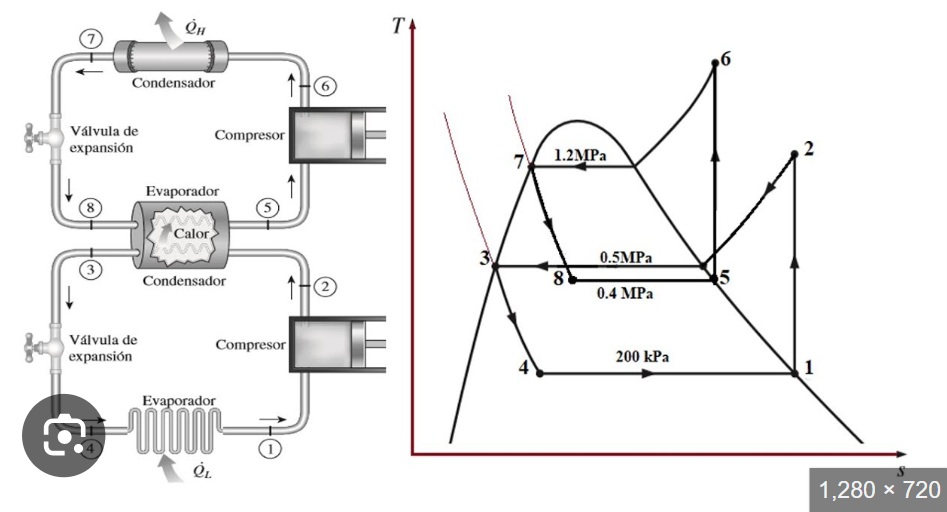

Antes de llamar al ciclo y resolver, se deben fijar dos cosas: Condiciones fijas a las cuales el sistema operará, y variables que se definen en el sistema. Con ello, se puede empezar la optimización del sistemas para cada refrigerante.

### Supuestos:

Se resuelve el ciclo de forma termodinámica; los parámetros como potencia entregada por el compresor, pérdida de carga en dispositivo de expansión, entre otros, se pueden ajustar en base al ciclo. Para ello, sí se deben tener en cuenta equipos reales que alcancen valores cercanos a los requeridos, o tengan potencia/revoluciones variables (inverter).

In [2]:
#Estos valores son fijos
T_chamber = -25 + 273.15 #K
T_out = 25 + 273.15 #K
Q = 200e3 #W a enfriar


#Estos valores son iniciales, ya que también pueden ser optimizados
pinch_ev_low = 8 #K, approach en evaporador de baja temperatura (si el ambiente está a -20°C, el evaporador opera a -28 °C)
pinch_cond_high = 8 #K, approach en condensador
eta_s = 0.8 #Eficiencia isentrópica
Tsc = 5 #K, subrenfriamiento en condensador
Tsh = 5 #k, sobrecalentamiento en evaporador
T_amb = 25 + 273.15 #K, temperatura ambiente

dif_cascada = 30

T_e_low = T_chamber - pinch_ev_low
T_c_low = T_e_low + dif_cascada #Se fija T° del condensador del primer ciclo para que la temperatura sea 30 grados más que en el evaporador

T_e_high = T_c_low - 10 #De tal manera que hayan 10 K de diferencia en el intercambiador
T_c_high = T_out + pinch_cond_high #Temperatura es mayor que el ambiente


fluid_low = 'R41'
fluid_high = 'R41'

#Y para el evaporador de baja temperatura
m_g_e_low = 1.5 #kg/s
rho_e_low = 850 #kg/m3
cp_e_low = 2100 #J/kgK

k_h = 0.13 #W/mk
mu_h = 3.5*10**(-3) #Pa*s

glicol = refrigerante(cp=cp_e_low, rho=rho_e_low, k=k_h, mu=mu_h) #Fluido caliente en el ev. para el ciclo de baja T
aire = refrigerante(cp=1000, rho=1, k=0.024, mu=1.81*10**(-5)) #Fluido frío en el cond. del ciclo de alta T

m_aire = 10 #kg/s

U_e_low = 200 #Caso base
U_c_high = 200 #Caso base

Np = 2 #Número de pasos
Nt = 80 #Número de tubos
di = 0.01 #m, diametro interno
t = 0.002 #m, espesor



In [3]:
HX_ev_low = HX(T_c_in=T_e_low, m_h=m_g_e_low, U=U_e_low, pinch=pinch_ev_low, Np=Np, Nt=Nt, di=di, t=t, fluid_c=fluid_low, fluid_h=glicol, tipo='evaporador')
HX_cond_high = HX(T_c_in=T_amb, U=U_c_high, pinch=pinch_ev_low, Np=Np, Nt=Nt, di=di, t=t, fluid_h=fluid_high, fluid_c=aire, tipo='condensador')


ciclo_combinado = VCR_cascada(Q=Q, T_ev_low=T_e_low, T_cond_low=T_c_low, T_ev_high=T_e_high, T_cond_high=T_c_high,
                              ref1=fluid_low, ref2=fluid_high, eta_c_low=eta_s, eta_c_high=eta_s,
                              Tsh=Tsh, Tsc=Tsc, T_amb=T_amb, ref_e_low=glicol, U_e_low=U_e_low, T_chamber=T_chamber,
                              m_g_e_low=m_g_e_low, m_aire=m_aire, HX_e_low=HX_ev_low, HX_c_high=HX_cond_high)

m_c = ciclo_combinado.m_dot_low

ciclo_combinado.ciclo()
ciclo_combinado.show()


          Resultados del Ciclo en Cascada
COP total:                     1.766
Costo total:              38.87 mil USD (por año)

--- Ciclo de Baja Temperatura ---
m_dot_low [kg/s]:         0.5521
W_comp_low [kW]:          36.829
Qc_low [kW]:              236.829
Pe_low [kPa]:             739.464
Pc_low [kPa]:             1879.013

--- Ciclo de Alta Temperatura ---
m_dot_high [kg/s]:        0.8914
W_comp_high [kW]:         76.453

Resultados en Evaporador de baja Temperatura

--- Parámetros del evaporador ---
Área [m]:                 34.495
T_lm [K]:                 28.990

Resultados en Condensador de alta Temperatura

--- Parámetros del condensador ---
Área [m]:                 79.625
T_lm [K]:                 19.672

Resultados en HX en cascada

--- Parámetros del HX en cascada ---
Área [m]:                 164.157

Exergía destruida
Evaporador LT [kW]:       13.982
Condensador HT [kW]:      13.991
HX cascada [kW]:          -13.001
Compresor LT [kW]:        7.101
Compresor HT [kW]

c:\Users\jose\OneDrive - Universidad Católica de Chile\10° Semestre\Simulación y Opti Sistemas\Códigos arreglados 2\Códigos arreglado\Códigos\clases.py:250: RuntimeWarning: overflow encountered in exp
  self.epsilon = (1 - np.exp(-NTU_v * (1 - C_r_v))) / (1 - C_r_v * np.exp(-NTU_v * (1 - C_r_v)))
c:\Users\jose\OneDrive - Universidad Católica de Chile\10° Semestre\Simulación y Opti Sistemas\Códigos arreglados 2\Códigos arreglado\Códigos\clases.py:250: RuntimeWarning: invalid value encountered in scalar divide
  self.epsilon = (1 - np.exp(-NTU_v * (1 - C_r_v))) / (1 - C_r_v * np.exp(-NTU_v * (1 - C_r_v)))


In [4]:
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.core.mixed import MixedVariableGA
from pymoo.algorithms.moo.nsga2 import RankAndCrowdingSurvival
from pymoo.termination import get_termination

# -------------------------------------------------
# Función que monta el sistema y devuelve métricas
# -------------------------------------------------
def componentes(pinch_ev, pinch_cond, T_dif):
    #Estos valores son fijos
    T_chamber = -25 + 273.15 #K
    T_out = 25 + 273.15 #K
    Q = 200e3 #W a enfriar


    eta_s = 0.8 #Eficiencia isentrópica
    Tsc = 5 #K, subrenfriamiento en condensador
    Tsh = 5 #k, sobrecalentamiento en evaporador
    T_amb = 25 + 273.15 #K, temperatura ambiente


    T_e_low = T_chamber - pinch_ev
    T_c_low = T_e_low + T_dif #Se fija T° del condensador del primer ciclo para que la temperatura sea 30 grados más que en el evaporador

    T_e_high = T_c_low - 10 #De tal manera que hayan 10 K de diferencia en el intercambiador
    T_c_high = T_out + pinch_cond #Temperatura es mayor que el ambiente


    fluid_low = 'R41'
    fluid_high = 'R41'

    #Y para el evaporador de baja temperatura
    m_g_e_low = 1.5 #kg/s
    rho_e_low = 850 #kg/m3
    cp_e_low = 2100 #J/kgK

    k_h = 0.13 #W/mk
    mu_h = 3.5*10**(-3) #Pa*s

    glicol = refrigerante(cp=cp_e_low, rho=rho_e_low, k=k_h, mu=mu_h) #Fluido caliente en el ev. para el ciclo de baja T
    aire = refrigerante(cp=1000, rho=1, k=0.024, mu=1.81*10**(-5)) #Fluido frío en el cond. del ciclo de alta T

    m_aire = 5 #kg/s

    U_e_low = 800 #Caso base
    U_c_high = 800 #Caso base

    Np = 2 #Número de pasos
    Nt = 80 #Número de tubos
    di = 0.01 #m, diametro interno
    t = 0.002 #m, espesor

    try:
        # crear intercambiadores usando los pinch dados
        HX_ev_low = HX(T_c_in=T_e_low, m_h=m_g_e_low, U=U_e_low, pinch=pinch_ev,
                       Np=Np, Nt=Nt, di=di, t=t,
                       fluid_c=fluid_low, fluid_h=glicol, tipo='evaporador')

        HX_cond_high = HX(T_c_in=T_amb, U=U_c_high, pinch=pinch_cond,
                          Np=Np, Nt=Nt, di=di, t=t,
                          fluid_h=fluid_high, fluid_c=aire, tipo='condensador')

        # instancia ciclo cascada con estos HX
        ciclo_combinado = VCR_cascada(Q=Q,
                                     T_ev_low=T_e_low, T_cond_low=T_e_low + T_dif,
                                     T_ev_high=T_e_high, T_cond_high=T_c_high,
                                     ref1=fluid_low, ref2=fluid_high,
                                     eta_c_low=eta_s, eta_c_high=eta_s,
                                     Tsh=Tsh, Tsc=Tsc, T_amb=T_amb,
                                     T_chamber=T_chamber, m_g_e_low=m_g_e_low, m_aire=m_aire,
                                     ref_e_low=glicol, U_e_low=U_e_low,
                                     HX_e_low=HX_ev_low, HX_c_high=HX_cond_high)

        # En caso de que tu clase calcule valores en init y solve, ya están listos
        COP = ciclo_combinado.COP
        costo = ciclo_combinado.costo
        Ex_d_total = ciclo_combinado.Ex_d_total

        # extrae otras variables para restricciones / diagnóstico
        T_lm_ev = ciclo_combinado.T_lm_e_low
        T_lm_cond = ciclo_combinado.T_lm_c_high
        m_dot_low = ciclo_combinado.m_dot_low
        m_dot_high = ciclo_combinado.m_dot_high
        Pe_low = ciclo_combinado.Pe_low
        Pc_low = ciclo_combinado.Pc_low
        Pe_high = ciclo_combinado.Pe_high
        Pc_high = ciclo_combinado.Pc_high

        A_e_low = ciclo_combinado.HX_e_l.A
        A_c_high = ciclo_combinado.HX_c_h.A
        A_HX = ciclo_combinado.A_HX

        out ={ 
            "COP": COP,
            "Ex_dest": Ex_d_total,
            "costo": costo,
            "T_lm_ev": T_lm_ev,
            "T_lm_cond": T_lm_cond,
            "m_dot_low": m_dot_low,
            "m_dot_high": m_dot_high,
            "Pe_low": Pe_low,
            "Pc_low": Pc_low,
            "Pe_high": Pe_high,
            "Pc_high": Pc_high,
            "A_e_low": A_e_low,
            "A_c_high": A_c_high,
            "A_HX": A_HX,
            "ok": True,
        }

    except Exception as e:
        out["ok"] = False

    return out

class ciclo_multi(ElementwiseProblem):
    def __init__(self):
        super().__init__(
            n_var=3, #Pinch en el ev. y cond. + Tdif cascada
            n_obj=3,  #Función objetivo: minimizar Ex_dest y C_total y maximizar COP
            n_constr=8, #
            xl=np.array([0.1, 0.1, 25]),
            xu=np.array([10, 10, 35])
        )
    
    
    def _evaluate(self, x, out, *args, **kwargs):
        solucion = componentes(x[0], x[1], x[2])
        COP = solucion["COP"]
        costo = solucion["costo"]
        Ex_d = solucion["Ex_dest"]

        m_dot_l = solucion["m_dot_low"]
        m_dot_h = solucion["m_dot_high"]
        Pc_low = solucion["Pc_low"]
        Pe_low = solucion["Pe_low"]
        Pc_high = solucion["Pc_high"]
        Pe_high = solucion["Pe_high"]
        Ae_low = solucion["A_e_low"]
        Ac_high = solucion["A_c_high"]
        AHX = solucion["A_HX"]


        #Restricc g<=0
        g1 = -m_dot_l
        g2 = -m_dot_h

        # Relación de compresión ≤ 8-10 para eficiencia y seguridad
        rc_low = Pc_low / Pe_low
        rc_high = Pc_high / Pe_high
        #g8 = rc_low - 50.0  # rc_low ≤ 10
        #g9 = rc_high - 50.0  # rc_high ≤ 10
        # Áreas mínimas y máximas para intercambiadores
        g10 = 0.1 - Ae_low    # A_evap ≥ 0.1 m²
        g11 = 0.1 - Ac_high   # A_cond ≥ 0.1 m²  
        g12 = 0.1 - AHX       # A_HX ≥ 0.1 m²

        g13 = Ae_low - 200     # A_evap ≤ 50 m²
        g14 = Ac_high - 200    # A_cond ≤ 50 m²
        g15 = AHX - 200        # A_HX ≤ 20 m²

        f1 = -COP
        f2 = costo
        f3 = Ex_d
        out["F"] = [f1, f2, f3]
        out["G"] = [g1, g2, g10, g11, g12, g13, g14, g15]
        #out["G"] = [g1, g2, g8, g9, g10, g11, g12, g13, g14, g15]

In [5]:
problema = ciclo_multi()
algoritmo = NSGA2(pop_size=100)

solucion = minimize(problema,
               algoritmo,
               ('n_gen', 50),
               seed=1,
               verbose=True)


n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      9 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |      200 |     15 |  0.000000E+00 |  0.000000E+00 |  0.0085639966 |         ideal
     3 |      300 |     30 |  0.000000E+00 |  0.000000E+00 |  0.1411921109 |         ideal
     4 |      400 |     40 |  0.000000E+00 |  0.000000E+00 |  0.0468077423 |         ideal
     5 |      500 |     62 |  0.000000E+00 |  0.000000E+00 |  0.0044814715 |         ideal
     6 |      600 |     78 |  0.000000E+00 |  0.000000E+00 |  0.0299582340 |         ideal
     7 |      700 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0563750860 |         ideal
     8 |      800 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0123582831 |         ideal
     9 |      900 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0235398688 |         ideal
    10 |     1000 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0025391361 |         nadir

## Análisis de Variables del Sistema vs Funciones Objetivo

A continuación se presentan gráficos de cada variable del sistema (df_vo) en función de las tres funciones objetivo: COP, Costo y Exergía Destruida (df_fo).

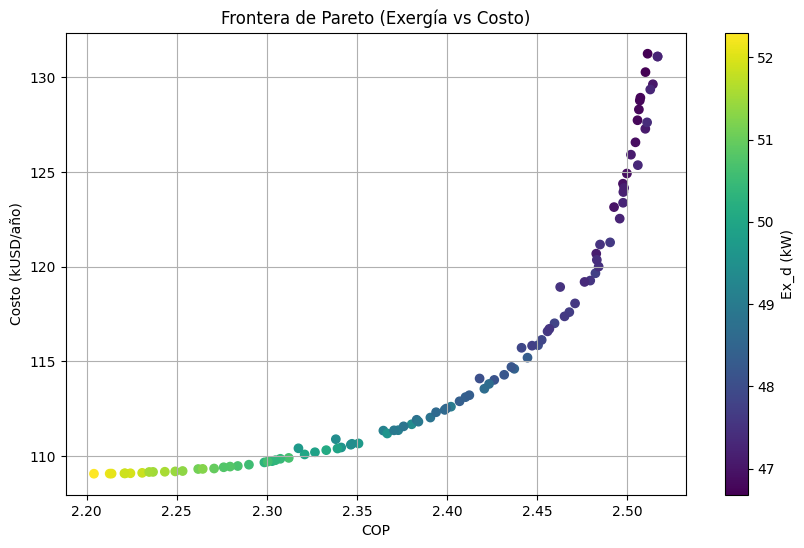

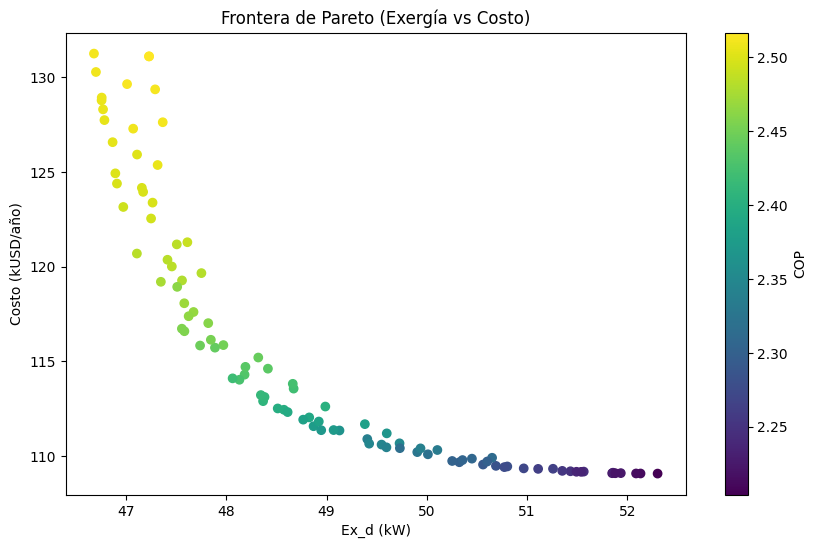

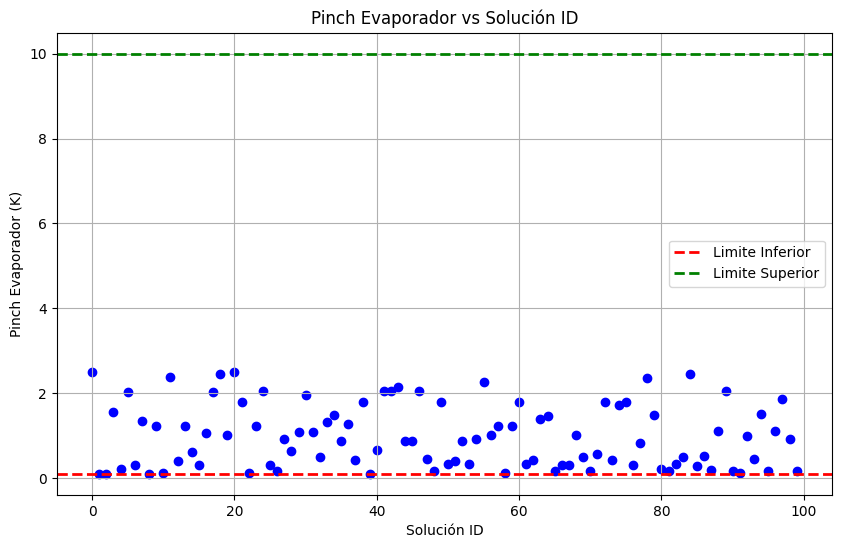

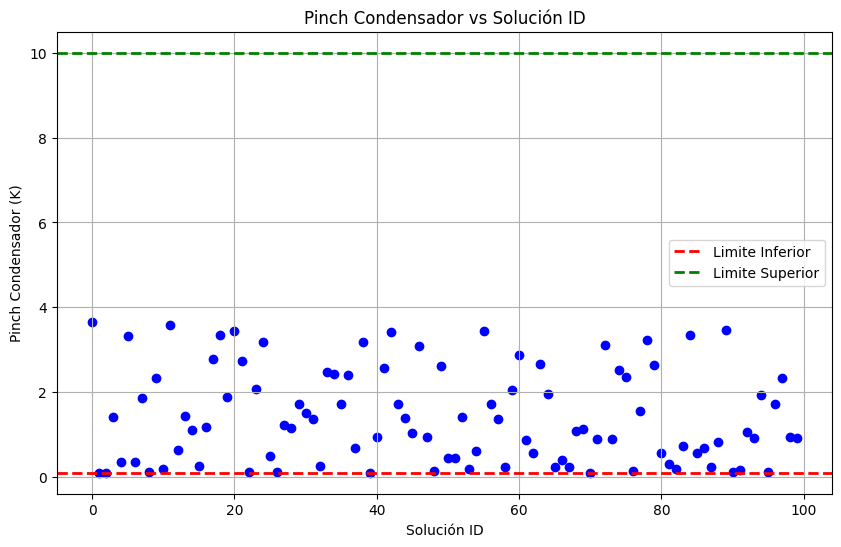

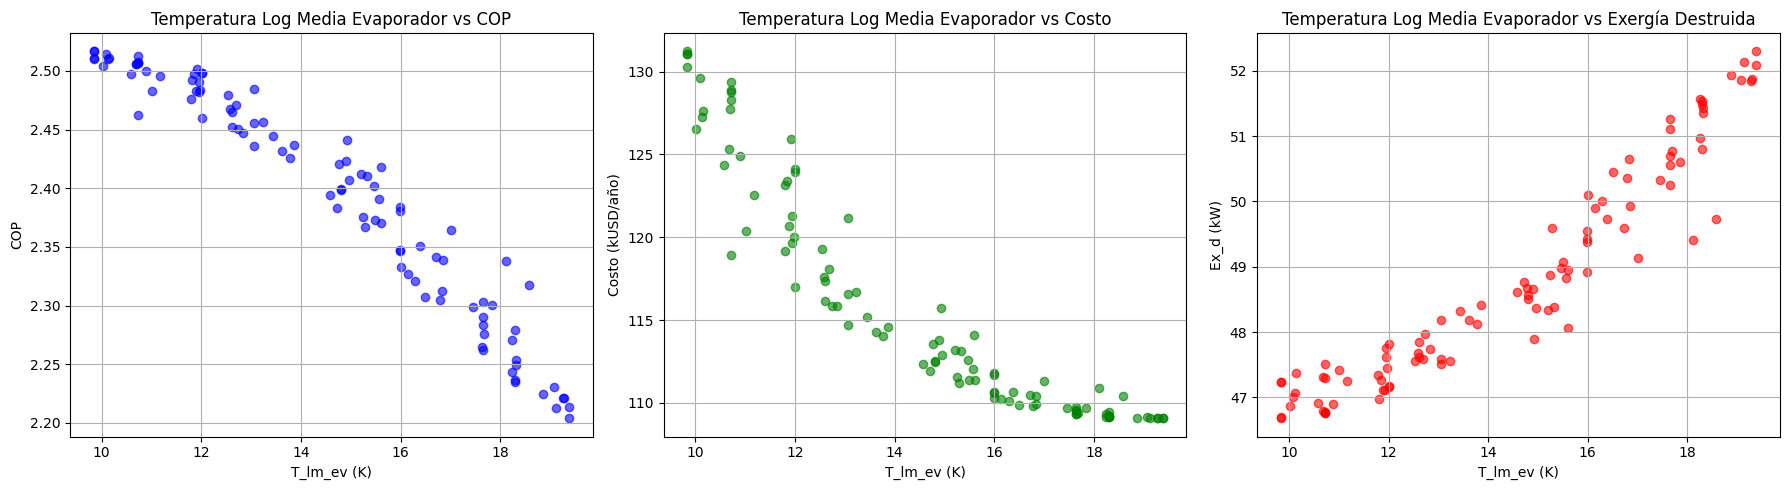

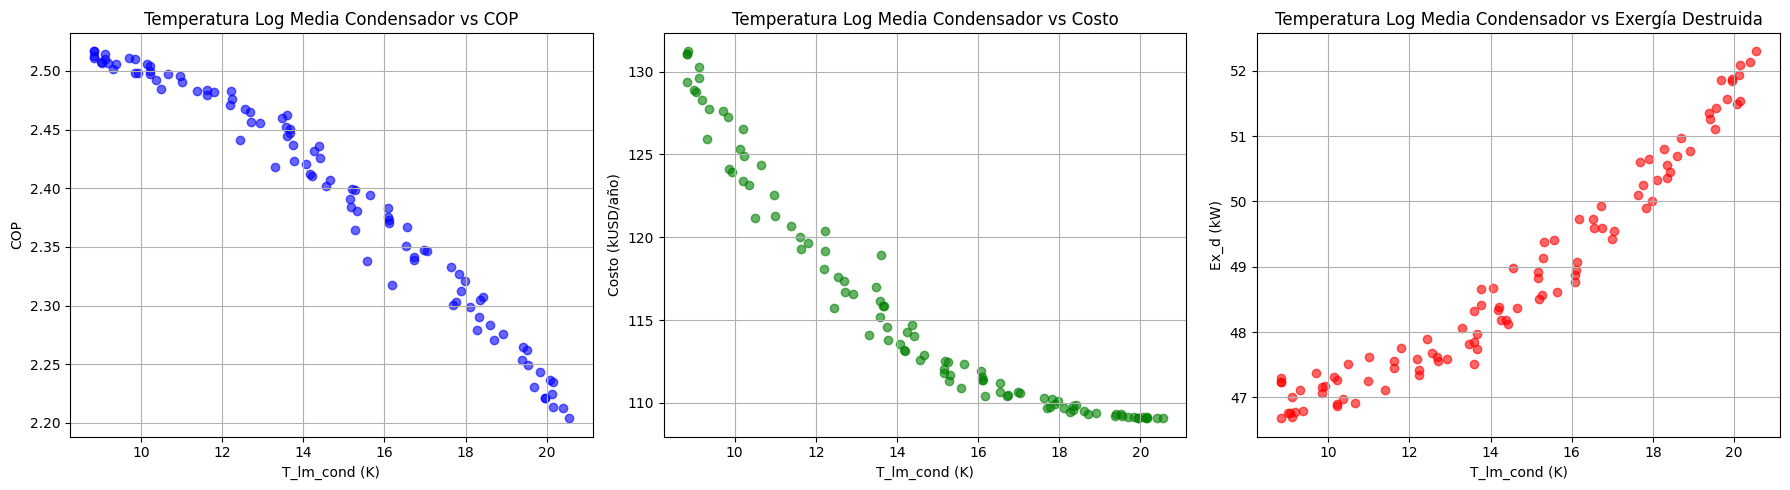

In [6]:
F = solucion.F   # matriz de objetivos [f1, f2]
X = solucion.X   # matriz de variables de decisión

df_fo = pd.DataFrame(F, columns=['-COP', 'Costo (USD/año)', 'Ex_d (W)'])
df_fo["-COP"] = -df_fo['-COP']
df_fo.rename(columns={'-COP': 'COP'}, inplace=True)

df_fo["Costo (USD/año)"] = df_fo["Costo (USD/año)"]/1000  #kUSD/año
df_fo.rename(columns={'Costo (USD/año)': 'Costo (kUSD/año)'}, inplace=True)

df_fo["Ex_d (W)"] = df_fo["Ex_d (W)"]/1000  #kW
df_fo.rename(columns={'Ex_d (W)': 'Ex_d (kW)'}, inplace=True)

df_vo = pd.DataFrame(X, columns=["pinch_e","pinch_cond", "T_casc" ])

variables = {"COP": [], "Ex_dest" : [], "costo": [] , "T_lm_ev": [], "T_lm_cond": [], "m_dot_low": [], "m_dot_high": [], "Pe_low": [], "Pc_low": [], "Pe_high": [], "Pc_high": [], "A_e_low": [], "A_c_high": [], "A_HX": [] }
for i in range(len(df_vo)):
    resultado = componentes(df_vo.loc[i, "pinch_e"], df_vo.loc[i, "pinch_cond"], df_vo.loc[i, "T_casc"])
    for key in variables.keys():
        variables[key].append(resultado[key])
for key in variables.keys():
    df_vo[key] = variables[key]

df_vo


plt.figure(figsize=(10,6))
plt.scatter(df_fo["COP"], df_fo["Costo (kUSD/año)"], c=df_fo["Ex_d (kW)"], cmap='viridis')
plt.colorbar(label='Ex_d (kW)')
plt.xlabel("COP")
plt.ylabel("Costo (kUSD/año)")
plt.title("Frontera de Pareto (Exergía vs Costo)")
plt.grid(True)
plt.show()


plt.figure(figsize=(10,6))
plt.scatter(df_fo['Ex_d (kW)'], df_fo['Costo (kUSD/año)'], c = df_fo["COP"], cmap = "viridis")
plt.ylabel('Costo (kUSD/año)')
plt.xlabel('Ex_d (kW)')
plt.colorbar(label='COP')
plt.title("Frontera de Pareto (Exergía vs Costo)")



n_id = [i for i in range(len(df_vo))]


xl=np.array([0.1, 0.1, 25])
xu=np.array([10, 10, 35])


plt.figure(figsize=(10,6))
plt.scatter(n_id, df_vo['pinch_e'], color='blue')
plt.axhline(y=xl[0], color='r', linestyle='--', linewidth=2, label='Limite Inferior')
plt.axhline(y=xu[0], color='g', linestyle='--', linewidth=2, label='Limite Superior')
plt.xlabel('Solución ID')
plt.ylabel('Pinch Evaporador (K)')
plt.title('Pinch Evaporador vs Solución ID')
plt.legend()
plt.grid(True)
plt.show()



plt.figure(figsize=(10,6))
plt.scatter(n_id, df_vo['pinch_cond'], color='blue')
plt.axhline(y=xl[1], color='r', linestyle='--', linewidth=2, label='Limite Inferior')
plt.axhline(y=xu[1], color='g', linestyle='--', linewidth=2, label='Limite Superior')
plt.xlabel('Solución ID')   
plt.ylabel('Pinch Condensador (K)')
plt.title('Pinch Condensador vs Solución ID')
plt.legend()
plt.grid(True)
plt.show()


# Temperatura logarítmica media del evaporador vs funciones objetivo
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(df_vo['T_lm_ev'], df_fo['COP'], alpha=0.6, color='blue')
axes[0].set_xlabel('T_lm_ev (K)')
axes[0].set_ylabel('COP')
axes[0].set_title('Temperatura Log Media Evaporador vs COP')
axes[0].grid(True)

axes[1].scatter(df_vo['T_lm_ev'], df_fo['Costo (kUSD/año)'], alpha=0.6, color='green')
axes[1].set_xlabel('T_lm_ev (K)')
axes[1].set_ylabel('Costo (kUSD/año)')
axes[1].set_title('Temperatura Log Media Evaporador vs Costo')
axes[1].grid(True)

axes[2].scatter(df_vo['T_lm_ev'], df_fo['Ex_d (kW)'], alpha=0.6, color='red')
axes[2].set_xlabel('T_lm_ev (K)')
axes[2].set_ylabel('Ex_d (kW)')
axes[2].set_title('Temperatura Log Media Evaporador vs Exergía Destruida')
axes[2].grid(True)

plt.tight_layout()
plt.show()

# Temperatura logarítmica media del condensador vs funciones objetivo
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(df_vo['T_lm_cond'], df_fo['COP'], alpha=0.6, color='blue')
axes[0].set_xlabel('T_lm_cond (K)')
axes[0].set_ylabel('COP')
axes[0].set_title('Temperatura Log Media Condensador vs COP')
axes[0].grid(True)

axes[1].scatter(df_vo['T_lm_cond'], df_fo['Costo (kUSD/año)'], alpha=0.6, color='green')
axes[1].set_xlabel('T_lm_cond (K)')
axes[1].set_ylabel('Costo (kUSD/año)')
axes[1].set_title('Temperatura Log Media Condensador vs Costo')
axes[1].grid(True)

axes[2].scatter(df_vo['T_lm_cond'], df_fo['Ex_d (kW)'], alpha=0.6, color='red')
axes[2].set_xlabel('T_lm_cond (K)')
axes[2].set_ylabel('Ex_d (kW)')
axes[2].set_title('Temperatura Log Media Condensador vs Exergía Destruida')
axes[2].grid(True)

plt.tight_layout()
plt.show()

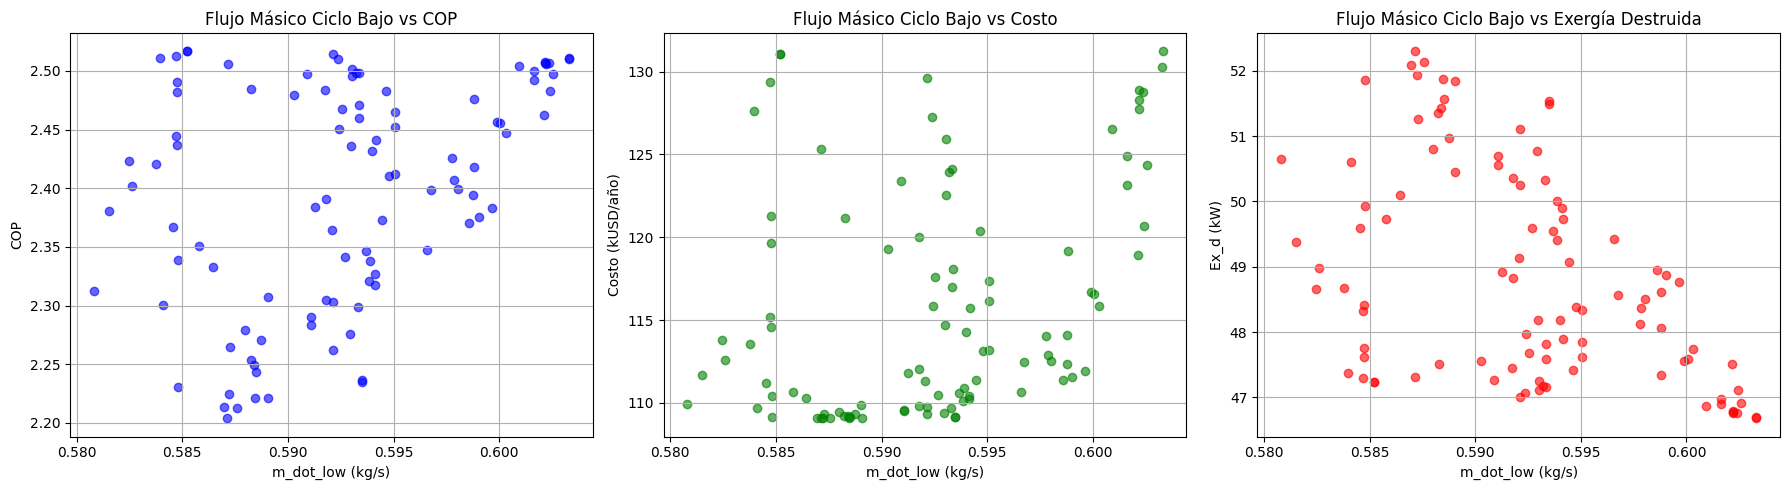

In [7]:
# Flujo másico ciclo bajo vs funciones objetivo
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(df_vo['m_dot_low'], df_fo['COP'], alpha=0.6, color='blue')
axes[0].set_xlabel('m_dot_low (kg/s)')
axes[0].set_ylabel('COP')
axes[0].set_title('Flujo Másico Ciclo Bajo vs COP')
axes[0].grid(True)

axes[1].scatter(df_vo['m_dot_low'], df_fo['Costo (kUSD/año)'], alpha=0.6, color='green')
axes[1].set_xlabel('m_dot_low (kg/s)')
axes[1].set_ylabel('Costo (kUSD/año)')
axes[1].set_title('Flujo Másico Ciclo Bajo vs Costo')
axes[1].grid(True)

axes[2].scatter(df_vo['m_dot_low'], df_fo['Ex_d (kW)'], alpha=0.6, color='red')
axes[2].set_xlabel('m_dot_low (kg/s)')
axes[2].set_ylabel('Ex_d (kW)')
axes[2].set_title('Flujo Másico Ciclo Bajo vs Exergía Destruida')
axes[2].grid(True)

plt.tight_layout()
plt.show()

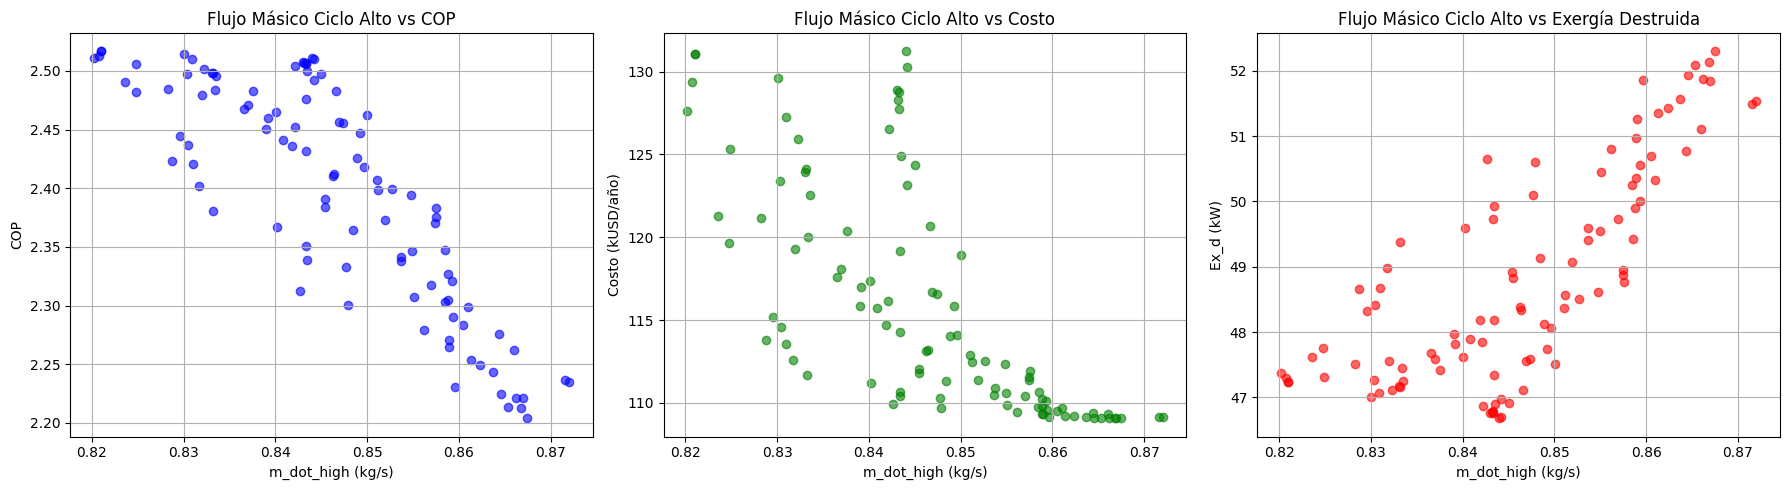

In [8]:
# Flujo másico ciclo alto vs funciones objetivo
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(df_vo['m_dot_high'], df_fo['COP'], alpha=0.6, color='blue')
axes[0].set_xlabel('m_dot_high (kg/s)')
axes[0].set_ylabel('COP')
axes[0].set_title('Flujo Másico Ciclo Alto vs COP')
axes[0].grid(True)

axes[1].scatter(df_vo['m_dot_high'], df_fo['Costo (kUSD/año)'], alpha=0.6, color='green')
axes[1].set_xlabel('m_dot_high (kg/s)')
axes[1].set_ylabel('Costo (kUSD/año)')
axes[1].set_title('Flujo Másico Ciclo Alto vs Costo')
axes[1].grid(True)

axes[2].scatter(df_vo['m_dot_high'], df_fo['Ex_d (kW)'], alpha=0.6, color='red')
axes[2].set_xlabel('m_dot_high (kg/s)')
axes[2].set_ylabel('Ex_d (kW)')
axes[2].set_title('Flujo Másico Ciclo Alto vs Exergía Destruida')
axes[2].grid(True)

plt.tight_layout()
plt.show()

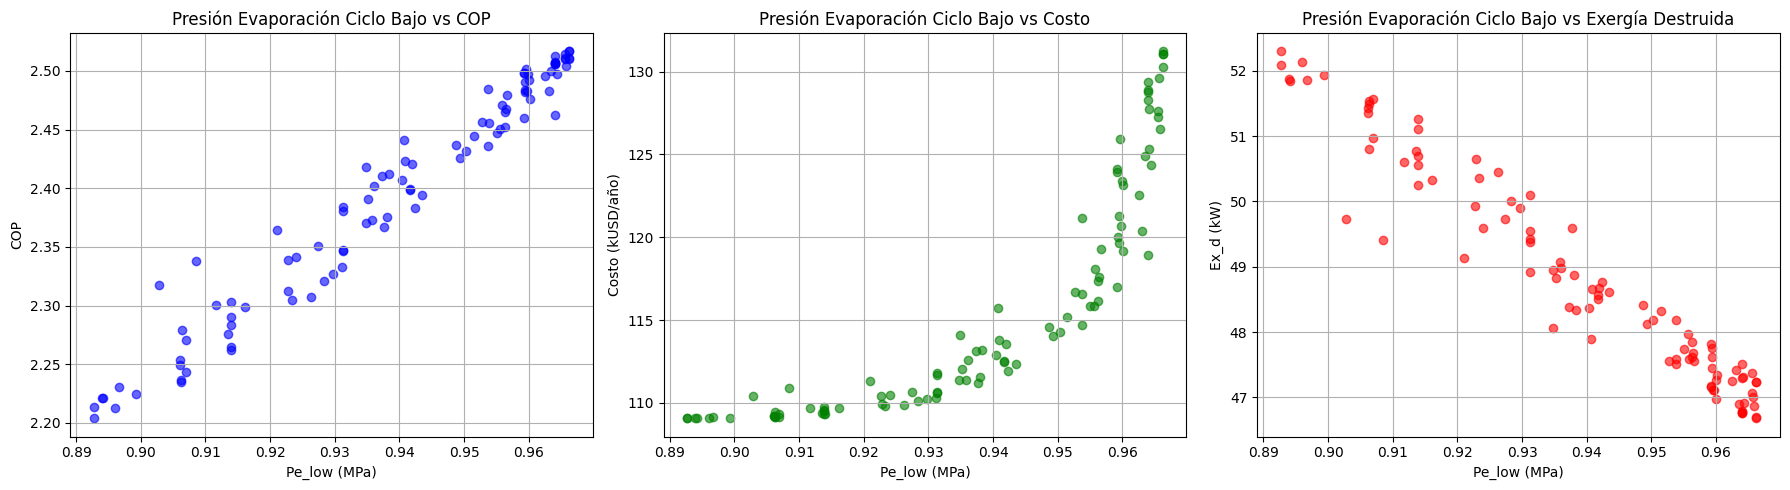

In [9]:
# Presión de evaporación ciclo bajo vs funciones objetivo (en MPa)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(df_vo['Pe_low']/1e6, df_fo['COP'], alpha=0.6, color='blue')
axes[0].set_xlabel('Pe_low (MPa)')
axes[0].set_ylabel('COP')
axes[0].set_title('Presión Evaporación Ciclo Bajo vs COP')
axes[0].grid(True)

axes[1].scatter(df_vo['Pe_low']/1e6, df_fo['Costo (kUSD/año)'], alpha=0.6, color='green')
axes[1].set_xlabel('Pe_low (MPa)')
axes[1].set_ylabel('Costo (kUSD/año)')
axes[1].set_title('Presión Evaporación Ciclo Bajo vs Costo')
axes[1].grid(True)

axes[2].scatter(df_vo['Pe_low']/1e6, df_fo['Ex_d (kW)'], alpha=0.6, color='red')
axes[2].set_xlabel('Pe_low (MPa)')
axes[2].set_ylabel('Ex_d (kW)')
axes[2].set_title('Presión Evaporación Ciclo Bajo vs Exergía Destruida')
axes[2].grid(True)

plt.tight_layout()
plt.show()

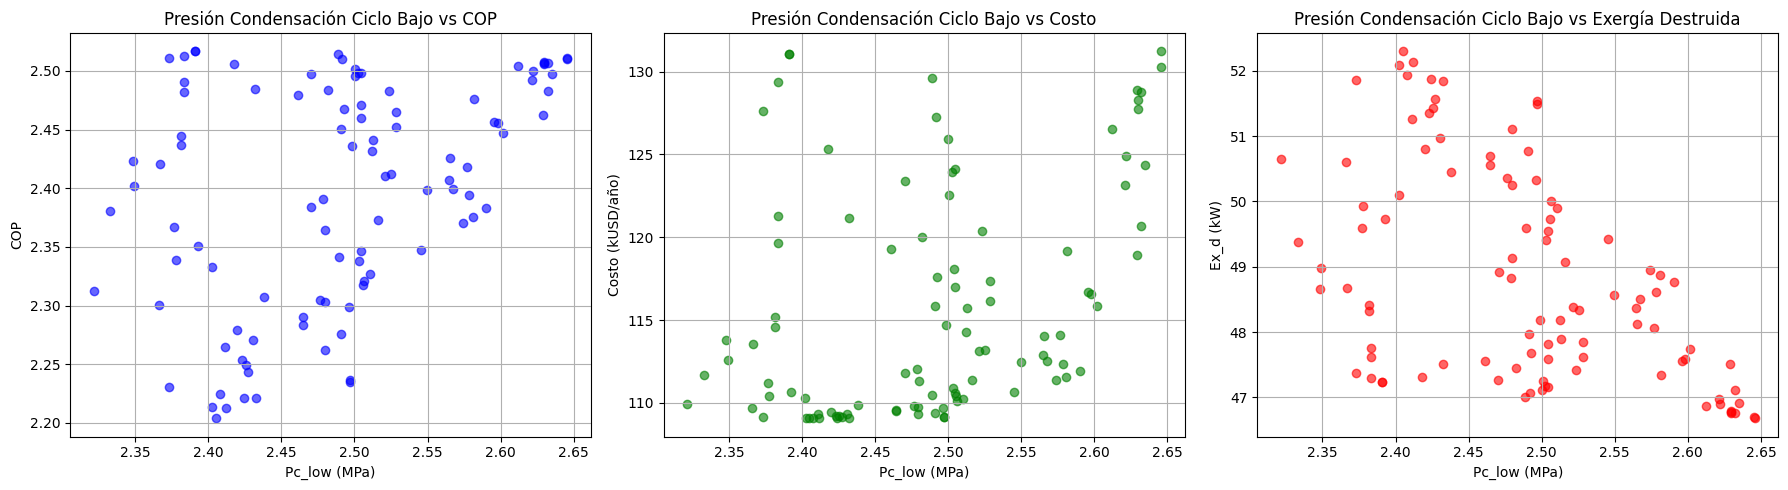

In [10]:
# Presión de condensación ciclo bajo vs funciones objetivo (en MPa)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(df_vo['Pc_low']/1e6, df_fo['COP'], alpha=0.6, color='blue')
axes[0].set_xlabel('Pc_low (MPa)')
axes[0].set_ylabel('COP')
axes[0].set_title('Presión Condensación Ciclo Bajo vs COP')
axes[0].grid(True)

axes[1].scatter(df_vo['Pc_low']/1e6, df_fo['Costo (kUSD/año)'], alpha=0.6, color='green')
axes[1].set_xlabel('Pc_low (MPa)')
axes[1].set_ylabel('Costo (kUSD/año)')
axes[1].set_title('Presión Condensación Ciclo Bajo vs Costo')
axes[1].grid(True)

axes[2].scatter(df_vo['Pc_low']/1e6, df_fo['Ex_d (kW)'], alpha=0.6, color='red')
axes[2].set_xlabel('Pc_low (MPa)')
axes[2].set_ylabel('Ex_d (kW)')
axes[2].set_title('Presión Condensación Ciclo Bajo vs Exergía Destruida')
axes[2].grid(True)

plt.tight_layout()
plt.show()

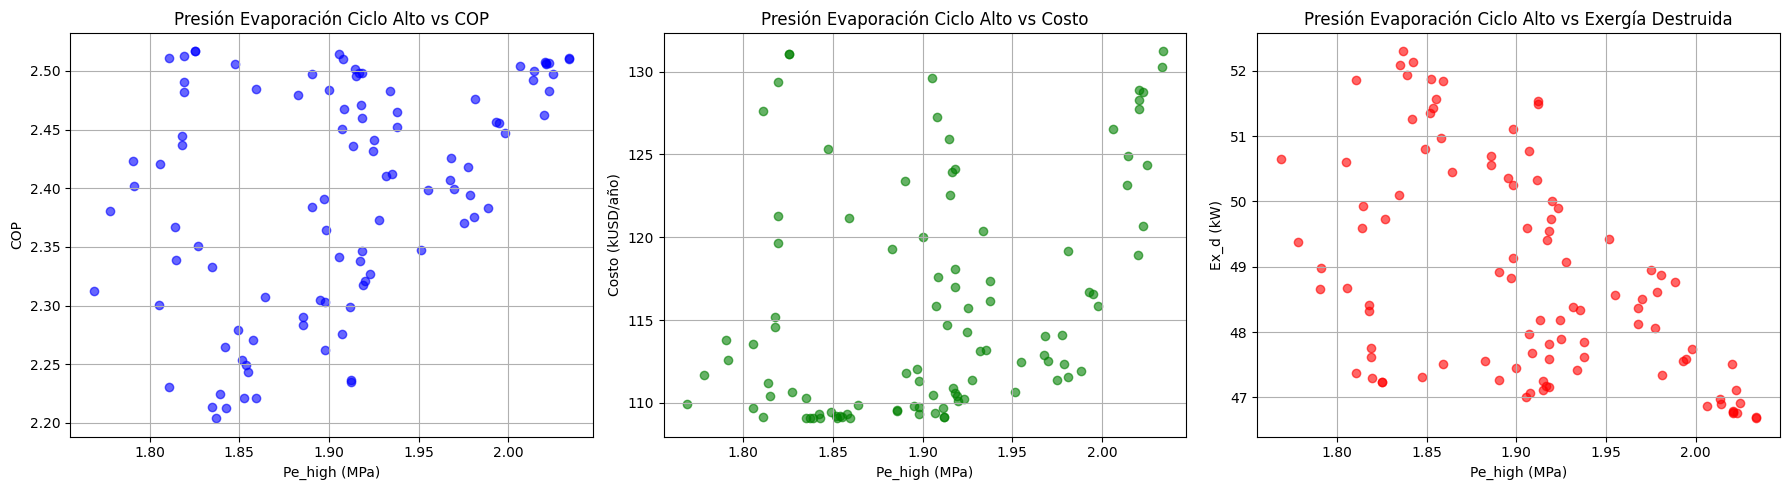

In [11]:
# Presión de evaporación ciclo alto vs funciones objetivo (en MPa)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(df_vo['Pe_high']/1e6, df_fo['COP'], alpha=0.6, color='blue')
axes[0].set_xlabel('Pe_high (MPa)')
axes[0].set_ylabel('COP')
axes[0].set_title('Presión Evaporación Ciclo Alto vs COP')
axes[0].grid(True)

axes[1].scatter(df_vo['Pe_high']/1e6, df_fo['Costo (kUSD/año)'], alpha=0.6, color='green')
axes[1].set_xlabel('Pe_high (MPa)')
axes[1].set_ylabel('Costo (kUSD/año)')
axes[1].set_title('Presión Evaporación Ciclo Alto vs Costo')
axes[1].grid(True)

axes[2].scatter(df_vo['Pe_high']/1e6, df_fo['Ex_d (kW)'], alpha=0.6, color='red')
axes[2].set_xlabel('Pe_high (MPa)')
axes[2].set_ylabel('Ex_d (kW)')
axes[2].set_title('Presión Evaporación Ciclo Alto vs Exergía Destruida')
axes[2].grid(True)

plt.tight_layout()
plt.show()

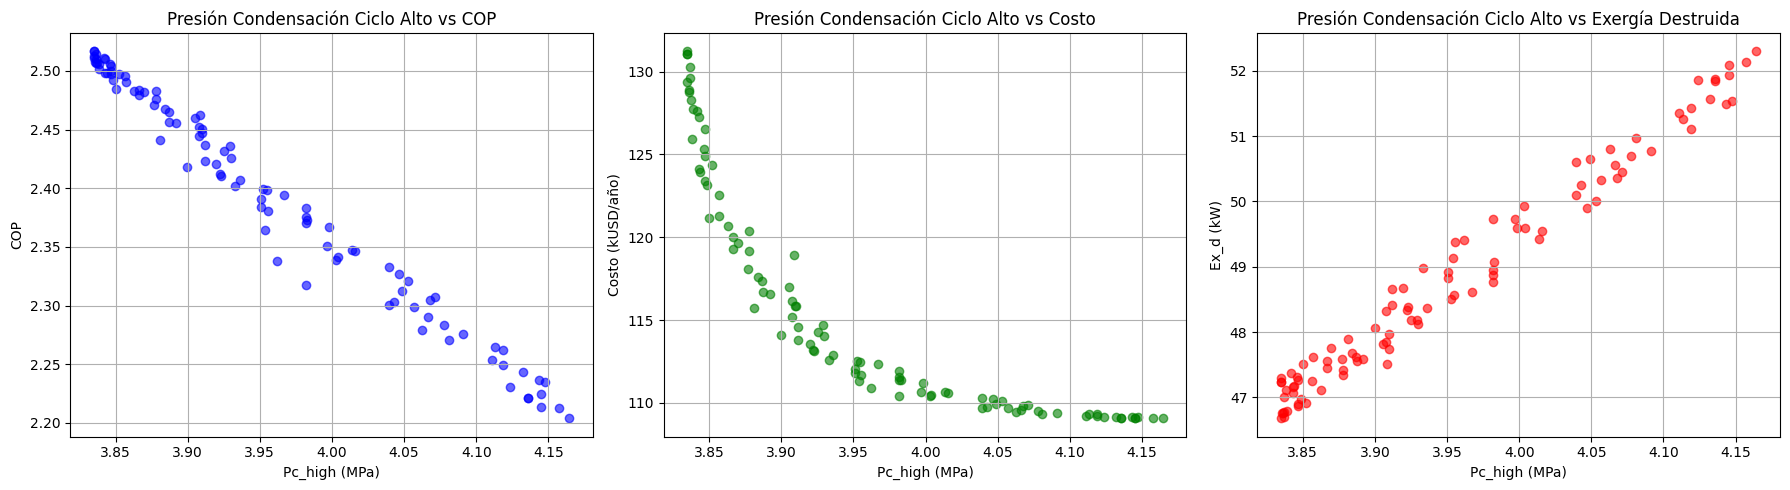

In [12]:
# Presión de condensación ciclo alto vs funciones objetivo (en MPa)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(df_vo['Pc_high']/1e6, df_fo['COP'], alpha=0.6, color='blue')
axes[0].set_xlabel('Pc_high (MPa)')
axes[0].set_ylabel('COP')
axes[0].set_title('Presión Condensación Ciclo Alto vs COP')
axes[0].grid(True)

axes[1].scatter(df_vo['Pc_high']/1e6, df_fo['Costo (kUSD/año)'], alpha=0.6, color='green')
axes[1].set_xlabel('Pc_high (MPa)')
axes[1].set_ylabel('Costo (kUSD/año)')
axes[1].set_title('Presión Condensación Ciclo Alto vs Costo')
axes[1].grid(True)

axes[2].scatter(df_vo['Pc_high']/1e6, df_fo['Ex_d (kW)'], alpha=0.6, color='red')
axes[2].set_xlabel('Pc_high (MPa)')
axes[2].set_ylabel('Ex_d (kW)')
axes[2].set_title('Presión Condensación Ciclo Alto vs Exergía Destruida')
axes[2].grid(True)

plt.tight_layout()
plt.show()

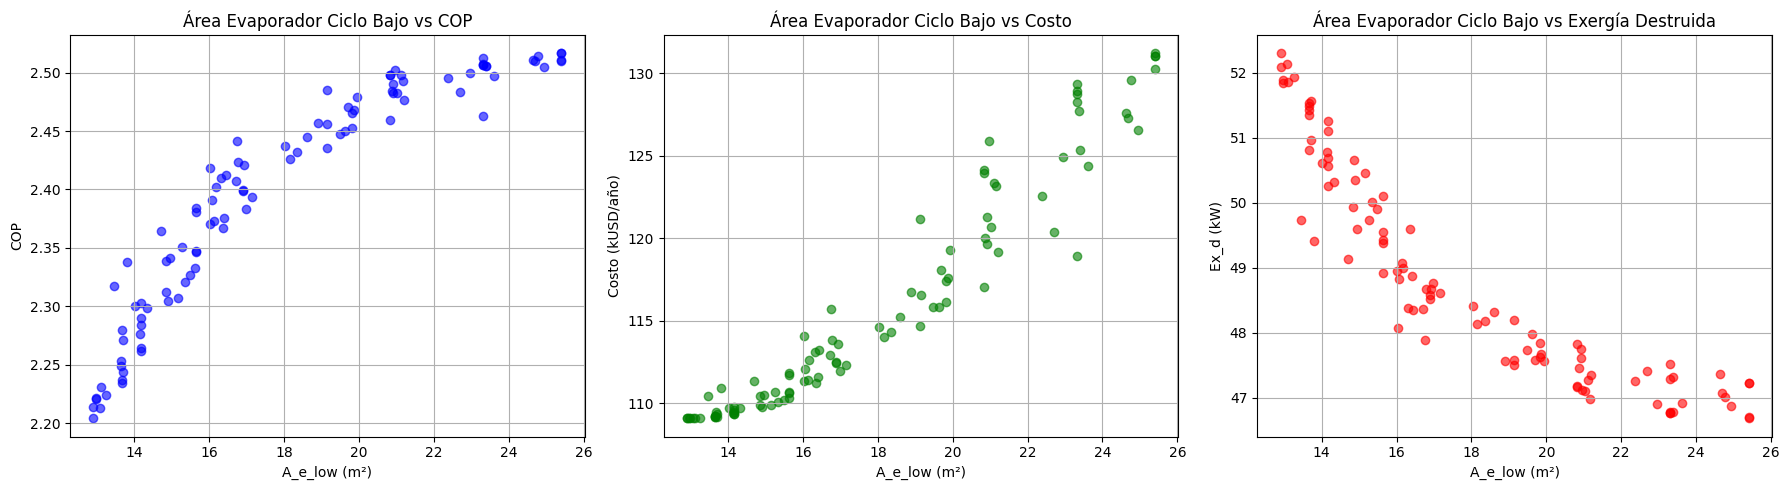

In [13]:
# Área evaporador ciclo bajo vs funciones objetivo
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(df_vo['A_e_low'], df_fo['COP'], alpha=0.6, color='blue')
axes[0].set_xlabel('A_e_low (m²)')
axes[0].set_ylabel('COP')
axes[0].set_title('Área Evaporador Ciclo Bajo vs COP')
axes[0].grid(True)

axes[1].scatter(df_vo['A_e_low'], df_fo['Costo (kUSD/año)'], alpha=0.6, color='green')
axes[1].set_xlabel('A_e_low (m²)')
axes[1].set_ylabel('Costo (kUSD/año)')
axes[1].set_title('Área Evaporador Ciclo Bajo vs Costo')
axes[1].grid(True)

axes[2].scatter(df_vo['A_e_low'], df_fo['Ex_d (kW)'], alpha=0.6, color='red')
axes[2].set_xlabel('A_e_low (m²)')
axes[2].set_ylabel('Ex_d (kW)')
axes[2].set_title('Área Evaporador Ciclo Bajo vs Exergía Destruida')
axes[2].grid(True)

plt.tight_layout()
plt.show()

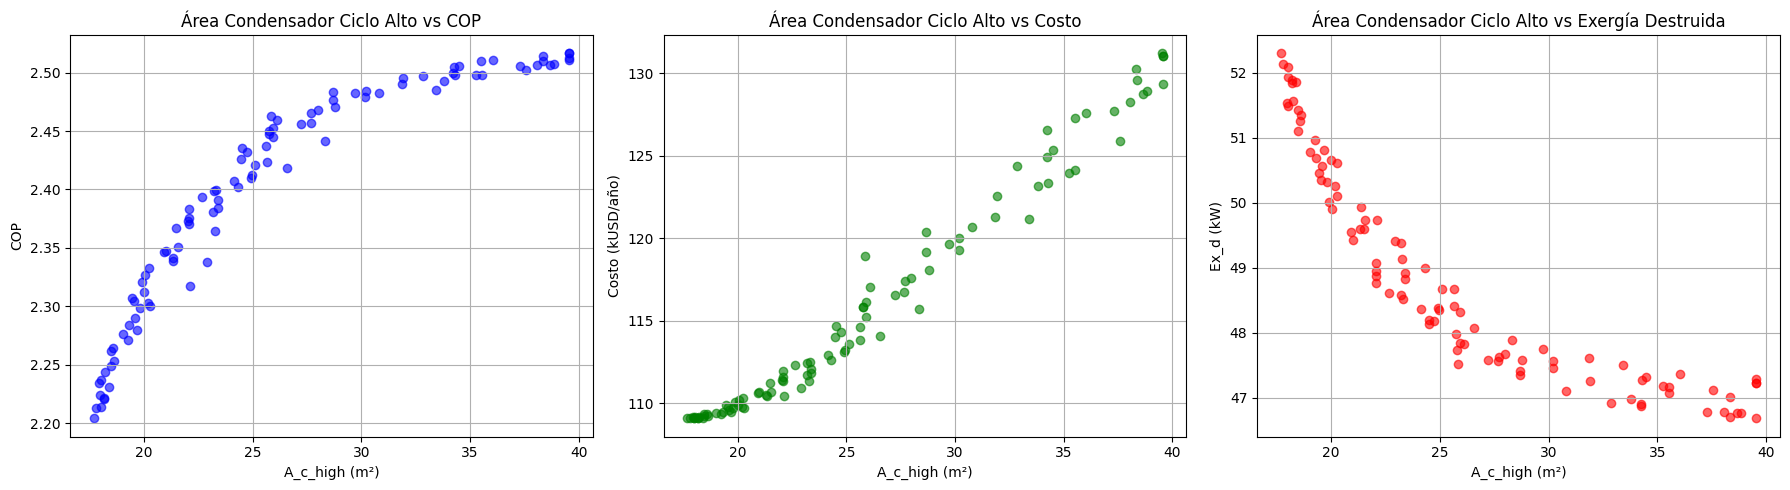

In [14]:
# Área condensador ciclo alto vs funciones objetivo
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(df_vo['A_c_high'], df_fo['COP'], alpha=0.6, color='blue')
axes[0].set_xlabel('A_c_high (m²)')
axes[0].set_ylabel('COP')
axes[0].set_title('Área Condensador Ciclo Alto vs COP')
axes[0].grid(True)

axes[1].scatter(df_vo['A_c_high'], df_fo['Costo (kUSD/año)'], alpha=0.6, color='green')
axes[1].set_xlabel('A_c_high (m²)')
axes[1].set_ylabel('Costo (kUSD/año)')
axes[1].set_title('Área Condensador Ciclo Alto vs Costo')
axes[1].grid(True)

axes[2].scatter(df_vo['A_c_high'], df_fo['Ex_d (kW)'], alpha=0.6, color='red')
axes[2].set_xlabel('A_c_high (m²)')
axes[2].set_ylabel('Ex_d (kW)')
axes[2].set_title('Área Condensador Ciclo Alto vs Exergía Destruida')
axes[2].grid(True)

plt.tight_layout()
plt.show()

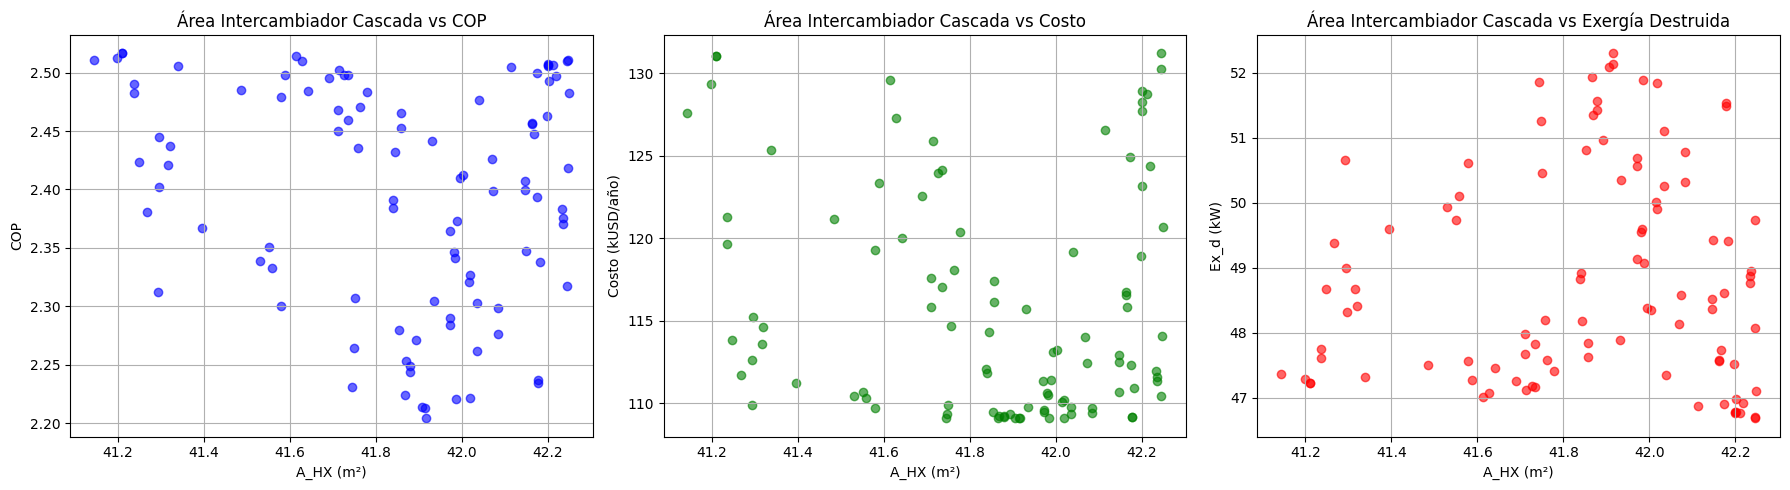

In [15]:
# Área intercambiador de cascada vs funciones objetivo
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(df_vo['A_HX'], df_fo['COP'], alpha=0.6, color='blue')
axes[0].set_xlabel('A_HX (m²)')
axes[0].set_ylabel('COP')
axes[0].set_title('Área Intercambiador Cascada vs COP')
axes[0].grid(True)

axes[1].scatter(df_vo['A_HX'], df_fo['Costo (kUSD/año)'], alpha=0.6, color='green')
axes[1].set_xlabel('A_HX (m²)')
axes[1].set_ylabel('Costo (kUSD/año)')
axes[1].set_title('Área Intercambiador Cascada vs Costo')
axes[1].grid(True)

axes[2].scatter(df_vo['A_HX'], df_fo['Ex_d (kW)'], alpha=0.6, color='red')
axes[2].set_xlabel('A_HX (m²)')
axes[2].set_ylabel('Ex_d (kW)')
axes[2].set_title('Área Intercambiador Cascada vs Exergía Destruida')
axes[2].grid(True)

plt.tight_layout()
plt.show()

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |     12 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |      200 |     20 |  0.000000E+00 |  0.000000E+00 |  0.0564208359 |         ideal
     3 |      300 |     26 |  0.000000E+00 |  0.000000E+00 |  0.0135851351 |         ideal
     4 |      400 |     30 |  0.000000E+00 |  0.000000E+00 |  0.0183303912 |         ideal
     5 |      500 |     41 |  0.000000E+00 |  0.000000E+00 |  0.0490220625 |         nadir
     6 |      600 |     57 |  0.000000E+00 |  0.000000E+00 |  0.0224957986 |         ideal
     7 |      700 |     77 |  0.000000E+00 |  0.000000E+00 |  0.0038512924 |         ideal
     8 |      800 |     97 |  0.000000E+00 |  0.000000E+00 |  0.0726748500 |         nadir
     9 |      900 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0162296321 |         ideal
    10 |     1000 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0063862523 |         ideal

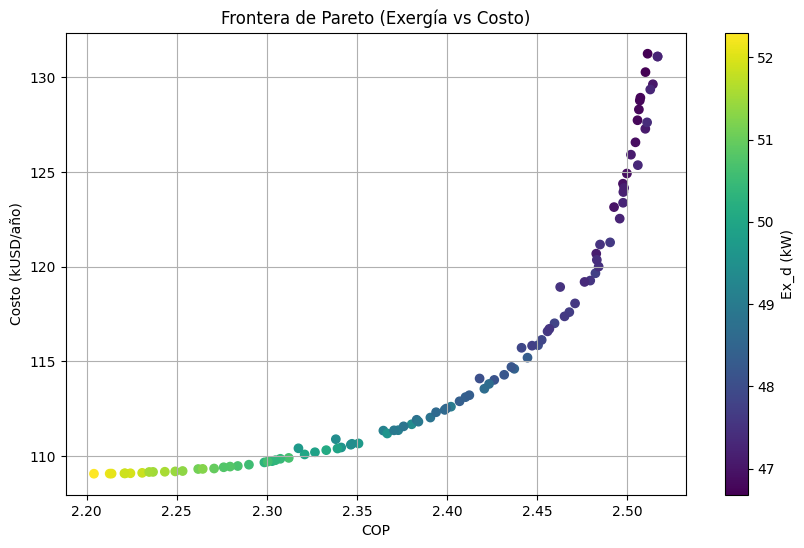

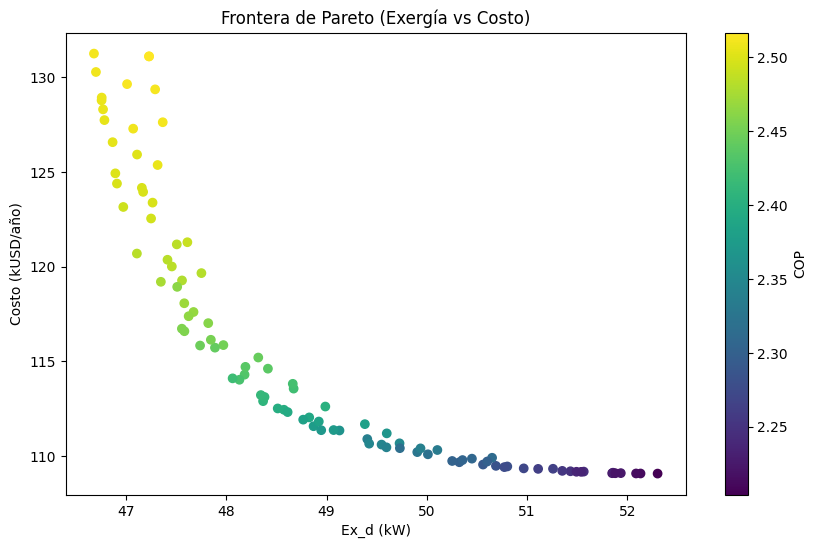

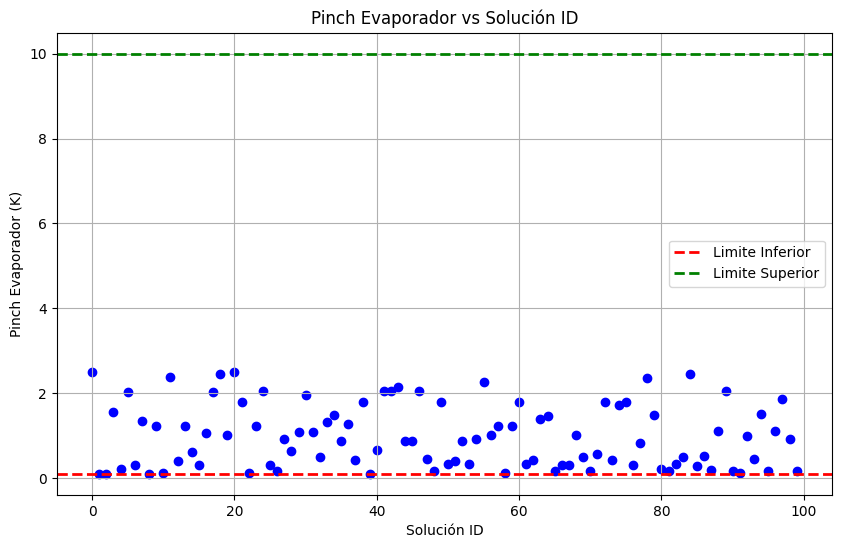

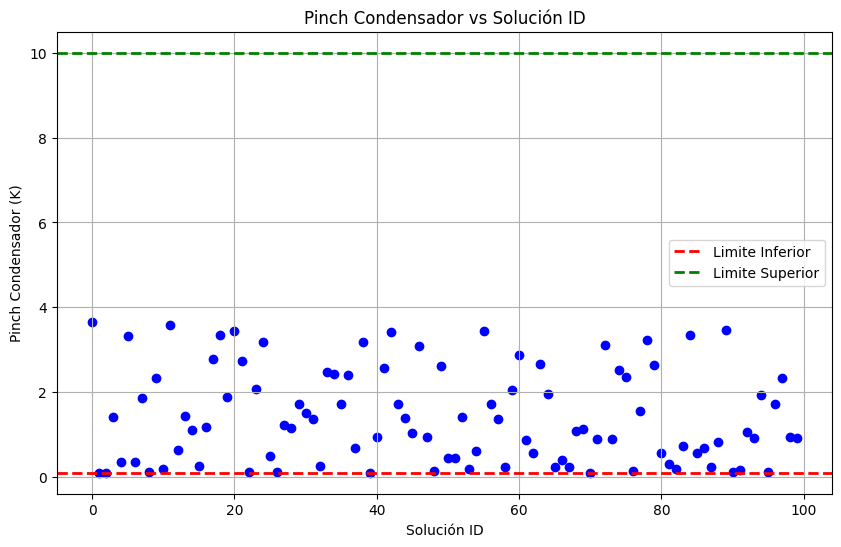

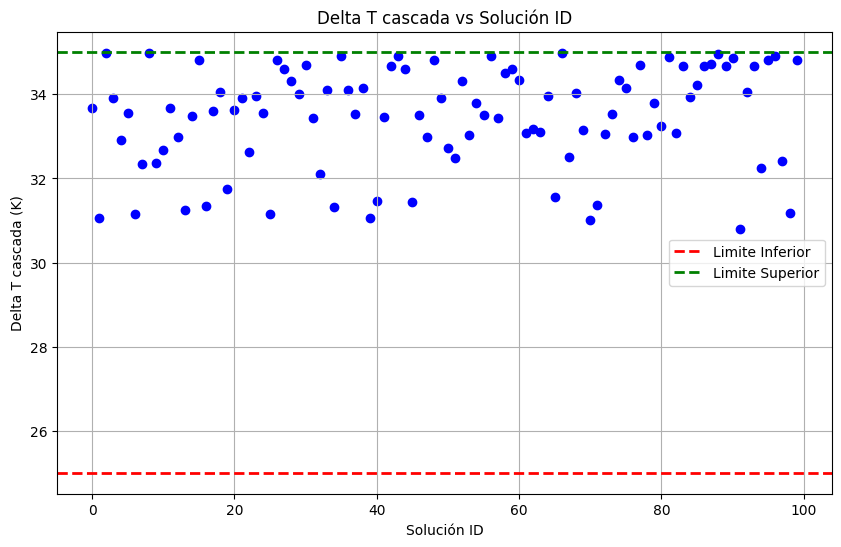

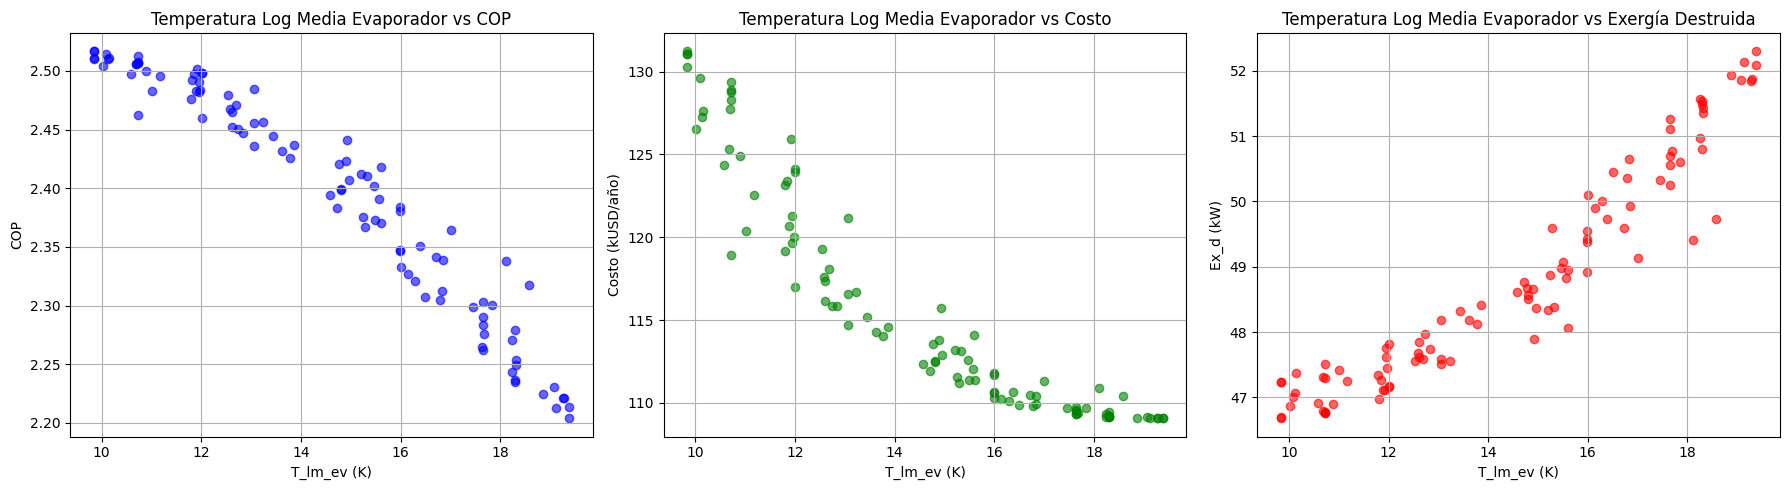

In [16]:
# -------------------------------------------------
# Función que monta el sistema y devuelve métricas
# -------------------------------------------------
def componentes2(pinch_ev, pinch_cond, T_dif):
    #Estos valores son fijos
    T_chamber = -25 + 273.15 #K
    T_out = 25 + 273.15 #K
    Q = 200e3 #W a enfriar


    eta_s = 0.8 #Eficiencia isentrópica
    Tsc = 5 #K, subrenfriamiento en condensador
    Tsh = 5 #k, sobrecalentamiento en evaporador
    T_amb = 25 + 273.15 #K, temperatura ambiente


    T_e_low = T_chamber - pinch_ev
    T_c_low = T_e_low + T_dif #Se fija T° del condensador del primer ciclo para que la temperatura sea 30 grados más que en el evaporador

    T_e_high = T_c_low - 10 #De tal manera que hayan 10 K de diferencia en el intercambiador
    T_c_high = T_out + pinch_cond #Temperatura es mayor que el ambiente


    fluid_low = 'R404A'
    fluid_high = 'R404A'

    #Y para el evaporador de baja temperatura
    m_g_e_low = 1.5 #kg/s
    rho_e_low = 850 #kg/m3
    cp_e_low = 2100 #J/kgK

    k_h = 0.13 #W/mk
    mu_h = 3.5*10**(-3) #Pa*s

    glicol = refrigerante(cp=cp_e_low, rho=rho_e_low, k=k_h, mu=mu_h) #Fluido caliente en el ev. para el ciclo de baja T
    aire = refrigerante(cp=1000, rho=1, k=0.024, mu=1.81*10**(-5)) #Fluido frío en el cond. del ciclo de alta T

    m_aire = 5 #kg/s

    U_e_low = 800 #Caso base
    U_c_high = 800 #Caso base

    Np = 2 #Número de pasos
    Nt = 80 #Número de tubos
    di = 0.01 #m, diametro interno
    t = 0.002 #m, espesor

    try:
        # crear intercambiadores usando los pinch dados
        HX_ev_low = HX(T_c_in=T_e_low, m_h=m_g_e_low, U=U_e_low, pinch=pinch_ev,
                       Np=Np, Nt=Nt, di=di, t=t,
                       fluid_c=fluid_low, fluid_h=glicol, tipo='evaporador')

        HX_cond_high = HX(T_c_in=T_amb, U=U_c_high, pinch=pinch_cond,
                          Np=Np, Nt=Nt, di=di, t=t,
                          fluid_h=fluid_high, fluid_c=aire, tipo='condensador')

        # instancia ciclo cascada con estos HX
        ciclo_combinado = VCR_cascada(Q=Q,
                                     T_ev_low=T_e_low, T_cond_low=T_e_low + T_dif,
                                     T_ev_high=T_e_high, T_cond_high=T_c_high,
                                     ref1=fluid_low, ref2=fluid_high,
                                     eta_c_low=eta_s, eta_c_high=eta_s,
                                     Tsh=Tsh, Tsc=Tsc, T_amb=T_amb,
                                     T_chamber=T_chamber, m_g_e_low=m_g_e_low, m_aire=m_aire,
                                     ref_e_low=glicol, U_e_low=U_e_low,
                                     HX_e_low=HX_ev_low, HX_c_high=HX_cond_high)

        # En caso de que tu clase calcule valores en init y solve, ya están listos
        COP = ciclo_combinado.COP
        costo = ciclo_combinado.costo
        Ex_d_total = ciclo_combinado.Ex_d_total

        # extrae otras variables para restricciones / diagnóstico
        T_lm_ev = ciclo_combinado.T_lm_e_low
        T_lm_cond = ciclo_combinado.T_lm_c_high
        m_dot_low = ciclo_combinado.m_dot_low
        m_dot_high = ciclo_combinado.m_dot_high
        Pe_low = ciclo_combinado.Pe_low
        Pc_low = ciclo_combinado.Pc_low
        Pe_high = ciclo_combinado.Pe_high
        Pc_high = ciclo_combinado.Pc_high

        A_e_low = ciclo_combinado.HX_e_l.A
        A_c_high = ciclo_combinado.HX_c_h.A
        A_HX = ciclo_combinado.A_HX

        out ={ 
            "COP": COP,
            "Ex_dest": Ex_d_total,
            "costo": costo,
            "T_lm_ev": T_lm_ev,
            "T_lm_cond": T_lm_cond,
            "m_dot_low": m_dot_low,
            "m_dot_high": m_dot_high,
            "Pe_low": Pe_low,
            "Pc_low": Pc_low,
            "Pe_high": Pe_high,
            "Pc_high": Pc_high,
            "A_e_low": A_e_low,
            "A_c_high": A_c_high,
            "A_HX": A_HX,
            "ok": True,
        }

    except Exception as e:
        out["ok"] = False

    return out



class ciclo_multi2(ElementwiseProblem):
    def __init__(self):
        super().__init__(
            n_var=3, #Pinch en el ev. y cond. + Tdif cascada
            n_obj=3,  #Función objetivo: minimizar Ex_dest y C_total y maximizar COP
            n_constr=8, #
            xl=np.array([0.1, 0.1, 25]),
            xu=np.array([10, 10, 35])
        )
    
    
    def _evaluate(self, x, out, *args, **kwargs):
        solucion = componentes2(x[0], x[1], x[2])
        COP = solucion["COP"]
        costo = solucion["costo"]
        Ex_d = solucion["Ex_dest"]

        m_dot_l = solucion["m_dot_low"]
        m_dot_h = solucion["m_dot_high"]
        Pc_low = solucion["Pc_low"]
        Pe_low = solucion["Pe_low"]
        Pc_high = solucion["Pc_high"]
        Pe_high = solucion["Pe_high"]
        Ae_low = solucion["A_e_low"]
        Ac_high = solucion["A_c_high"]
        AHX = solucion["A_HX"]


        #Restricc g<=0
        g1 = -m_dot_l
        g2 = -m_dot_h

        # Relación de compresión ≤ 8-10 para eficiencia y seguridad
        rc_low = Pc_low / Pe_low
        rc_high = Pc_high / Pe_high
        #g8 = rc_low - 50.0  # rc_low ≤ 10
        #g9 = rc_high - 50.0  # rc_high ≤ 10
        # Áreas mínimas y máximas para intercambiadores
        g10 = 0.1 - Ae_low    # A_evap ≥ 0.1 m²
        g11 = 0.1 - Ac_high   # A_cond ≥ 0.1 m²  
        g12 = 0.1 - AHX       # A_HX ≥ 0.1 m²

        g13 = Ae_low - 200     # A_evap ≤ 50 m²
        g14 = Ac_high - 200    # A_cond ≤ 50 m²
        g15 = AHX - 200        # A_HX ≤ 20 m²

        f1 = -COP
        f2 = costo
        f3 = Ex_d
        out["F"] = [f1, f2, f3]
        out["G"] = [g1, g2, g10, g11, g12, g13, g14, g15]
        #out["G"] = [g1, g2, g8, g9, g10, g11, g12, g13, g14, g15]


problema2 = ciclo_multi2()

solucion2 = minimize(problema2,
               algoritmo,
               ('n_gen', 50),
               seed=1,
               verbose=True)




F2 = solucion2.F   # matriz de objetivos [f1, f2]
X2 = solucion2.X   # matriz de variables de decisión

df_fo = pd.DataFrame(F, columns=['-COP', 'Costo (USD/año)', 'Ex_d (W)'])
df_fo["-COP"] = -df_fo['-COP']
df_fo.rename(columns={'-COP': 'COP'}, inplace=True)

df_fo["Costo (USD/año)"] = df_fo["Costo (USD/año)"]/1000  #kUSD/año
df_fo.rename(columns={'Costo (USD/año)': 'Costo (kUSD/año)'}, inplace=True)

df_fo["Ex_d (W)"] = df_fo["Ex_d (W)"]/1000  #kW
df_fo.rename(columns={'Ex_d (W)': 'Ex_d (kW)'}, inplace=True)

df_vo = pd.DataFrame(X, columns=["pinch_e","pinch_cond", "T_casc" ])

variables = {"COP": [], "Ex_dest" : [], "costo": [] , "T_lm_ev": [], "T_lm_cond": [], "m_dot_low": [], "m_dot_high": [], "Pe_low": [], "Pc_low": [], "Pe_high": [], "Pc_high": [], "A_e_low": [], "A_c_high": [], "A_HX": [] }
for i in range(len(df_vo)):
    resultado = componentes(df_vo.loc[i, "pinch_e"], df_vo.loc[i, "pinch_cond"], df_vo.loc[i, "T_casc"])
    for key in variables.keys():
        variables[key].append(resultado[key])
for key in variables.keys():
    df_vo[key] = variables[key]

df_vo


plt.figure(figsize=(10,6))
plt.scatter(df_fo["COP"], df_fo["Costo (kUSD/año)"], c=df_fo["Ex_d (kW)"], cmap='viridis')
plt.colorbar(label='Ex_d (kW)')
plt.xlabel("COP")
plt.ylabel("Costo (kUSD/año)")
plt.title("Frontera de Pareto (Exergía vs Costo)")
plt.grid(True)
plt.show()


plt.figure(figsize=(10,6))
plt.scatter(df_fo['Ex_d (kW)'], df_fo['Costo (kUSD/año)'], c = df_fo["COP"], cmap = "viridis")
plt.ylabel('Costo (kUSD/año)')
plt.xlabel('Ex_d (kW)')
plt.colorbar(label='COP')
plt.title("Frontera de Pareto (Exergía vs Costo)")



n_id = [i for i in range(len(df_vo))]


xl=np.array([0.1, 0.1, 25])
xu=np.array([10, 10, 35])


plt.figure(figsize=(10,6))
plt.scatter(n_id, df_vo['pinch_e'], color='blue')
plt.axhline(y=xl[0], color='r', linestyle='--', linewidth=2, label='Limite Inferior')
plt.axhline(y=xu[0], color='g', linestyle='--', linewidth=2, label='Limite Superior')
plt.xlabel('Solución ID')
plt.ylabel('Pinch Evaporador (K)')
plt.title('Pinch Evaporador vs Solución ID')
plt.legend()
plt.grid(True)
plt.show()



plt.figure(figsize=(10,6))
plt.scatter(n_id, df_vo['pinch_cond'], color='blue')
plt.axhline(y=xl[1], color='r', linestyle='--', linewidth=2, label='Limite Inferior')
plt.axhline(y=xu[1], color='g', linestyle='--', linewidth=2, label='Limite Superior')
plt.xlabel('Solución ID')   
plt.ylabel('Pinch Condensador (K)')
plt.title('Pinch Condensador vs Solución ID')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
plt.scatter(n_id, df_vo['T_casc'], color='blue')
plt.axhline(y=xl[2], color='r', linestyle='--', linewidth=2, label='Limite Inferior')
plt.axhline(y=xu[2], color='g', linestyle='--', linewidth=2, label='Limite Superior')
plt.xlabel('Solución ID')   
plt.ylabel('Delta T cascada (K)')
plt.title('Delta T cascada vs Solución ID')
plt.legend()
plt.grid(True)
plt.show()


# Temperatura logarítmica media del evaporador vs funciones objetivo
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(df_vo['T_lm_ev'], df_fo['COP'], alpha=0.6, color='blue')
axes[0].set_xlabel('T_lm_ev (K)')
axes[0].set_ylabel('COP')
axes[0].set_title('Temperatura Log Media Evaporador vs COP')
axes[0].grid(True)

axes[1].scatter(df_vo['T_lm_ev'], df_fo['Costo (kUSD/año)'], alpha=0.6, color='green')
axes[1].set_xlabel('T_lm_ev (K)')
axes[1].set_ylabel('Costo (kUSD/año)')
axes[1].set_title('Temperatura Log Media Evaporador vs Costo')
axes[1].grid(True)

axes[2].scatter(df_vo['T_lm_ev'], df_fo['Ex_d (kW)'], alpha=0.6, color='red')
axes[2].set_xlabel('T_lm_ev (K)')
axes[2].set_ylabel('Ex_d (kW)')
axes[2].set_title('Temperatura Log Media Evaporador vs Exergía Destruida')
axes[2].grid(True)

plt.tight_layout()
plt.show()

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |     12 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |      200 |     18 |  0.000000E+00 |  0.000000E+00 |  0.0033524109 |         ideal
     3 |      300 |     31 |  0.000000E+00 |  0.000000E+00 |  0.0763615166 |         ideal
     4 |      400 |     47 |  0.000000E+00 |  0.000000E+00 |  0.0028896166 |         ideal
     5 |      500 |     64 |  0.000000E+00 |  0.000000E+00 |  0.0147407100 |         ideal
     6 |      600 |     74 |  0.000000E+00 |  0.000000E+00 |  0.0212380972 |         nadir
     7 |      700 |     89 |  0.000000E+00 |  0.000000E+00 |  0.0070124786 |         ideal
     8 |      800 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0079091549 |         ideal
     9 |      900 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0118120151 |         ideal
    10 |     1000 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0462857676 |         nadir

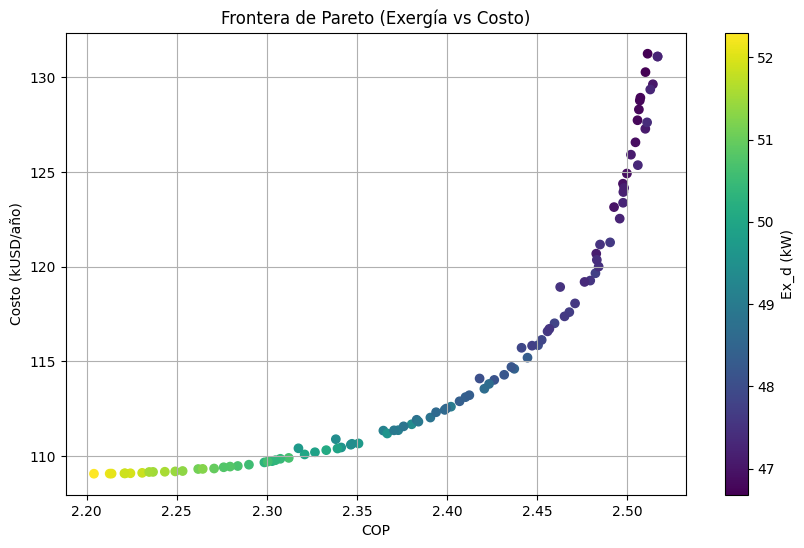

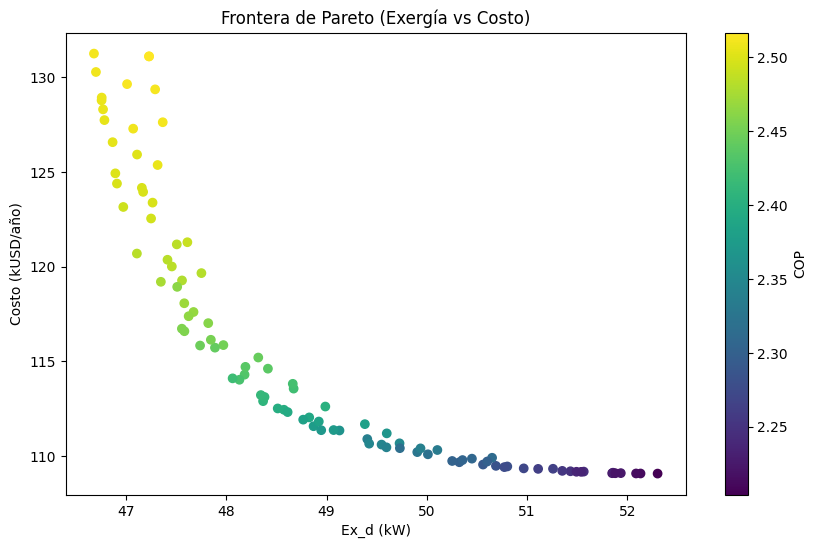

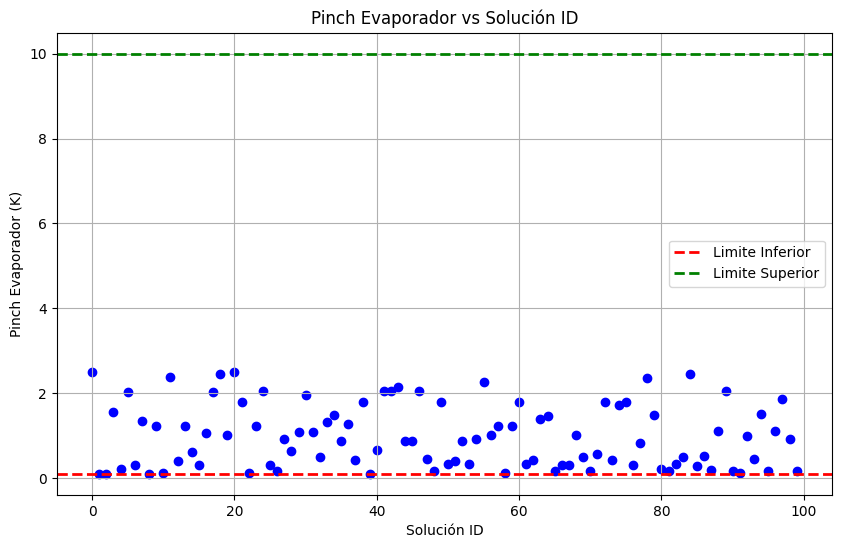

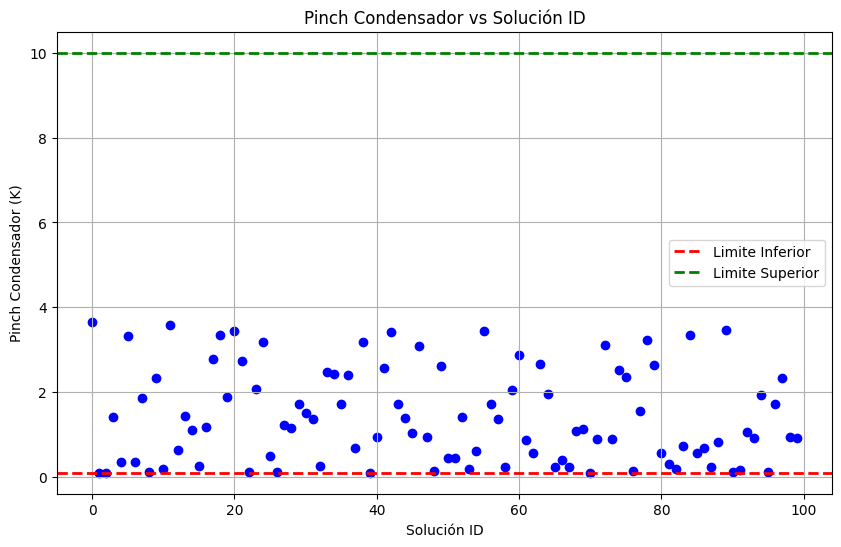

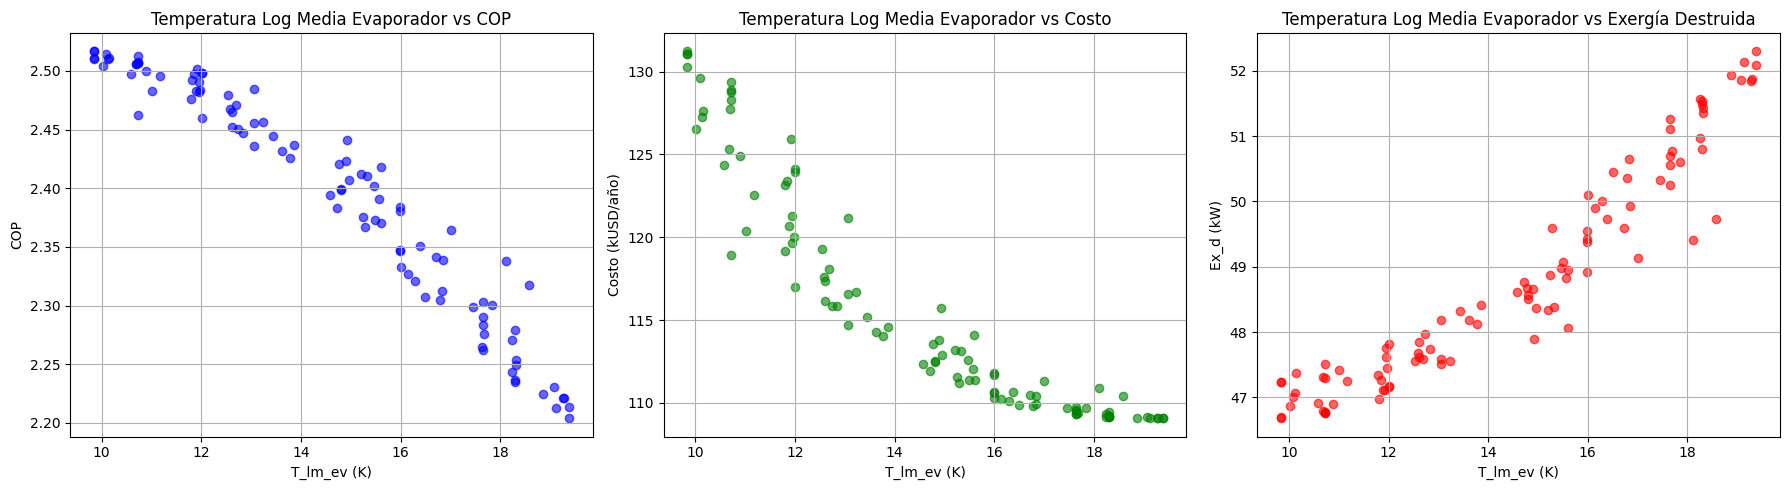

In [17]:
# -------------------------------------------------
# Función que monta el sistema y devuelve métricas
# -------------------------------------------------
def componentes3(pinch_ev, pinch_cond, T_dif):
    #Estos valores son fijos
    T_chamber = -25 + 273.15 #K
    T_out = 25 + 273.15 #K
    Q = 200e3 #W a enfriar


    eta_s = 0.8 #Eficiencia isentrópica
    Tsc = 5 #K, subrenfriamiento en condensador
    Tsh = 5 #k, sobrecalentamiento en evaporador
    T_amb = 25 + 273.15 #K, temperatura ambiente


    T_e_low = T_chamber - pinch_ev
    T_c_low = T_e_low + T_dif #Se fija T° del condensador del primer ciclo para que la temperatura sea 30 grados más que en el evaporador

    T_e_high = T_c_low - 10 #De tal manera que hayan 10 K de diferencia en el intercambiador
    T_c_high = T_out + pinch_cond #Temperatura es mayor que el ambiente


    fluid_low = 'R290'
    fluid_high = 'R290'

    #Y para el evaporador de baja temperatura
    m_g_e_low = 1.5 #kg/s
    rho_e_low = 850 #kg/m3
    cp_e_low = 2100 #J/kgK

    k_h = 0.13 #W/mk
    mu_h = 3.5*10**(-3) #Pa*s

    glicol = refrigerante(cp=cp_e_low, rho=rho_e_low, k=k_h, mu=mu_h) #Fluido caliente en el ev. para el ciclo de baja T
    aire = refrigerante(cp=1000, rho=1, k=0.024, mu=1.81*10**(-5)) #Fluido frío en el cond. del ciclo de alta T

    m_aire = 5 #kg/s

    U_e_low = 800 #Caso base
    U_c_high = 800 #Caso base

    Np = 2 #Número de pasos
    Nt = 80 #Número de tubos
    di = 0.01 #m, diametro interno
    t = 0.002 #m, espesor

    try:
        # crear intercambiadores usando los pinch dados
        HX_ev_low = HX(T_c_in=T_e_low, m_h=m_g_e_low, U=U_e_low, pinch=pinch_ev,
                       Np=Np, Nt=Nt, di=di, t=t,
                       fluid_c=fluid_low, fluid_h=glicol, tipo='evaporador')

        HX_cond_high = HX(T_c_in=T_amb, U=U_c_high, pinch=pinch_cond,
                          Np=Np, Nt=Nt, di=di, t=t,
                          fluid_h=fluid_high, fluid_c=aire, tipo='condensador')

        # instancia ciclo cascada con estos HX
        ciclo_combinado = VCR_cascada(Q=Q,
                                     T_ev_low=T_e_low, T_cond_low=T_e_low + T_dif,
                                     T_ev_high=T_e_high, T_cond_high=T_c_high,
                                     ref1=fluid_low, ref2=fluid_high,
                                     eta_c_low=eta_s, eta_c_high=eta_s,
                                     Tsh=Tsh, Tsc=Tsc, T_amb=T_amb,
                                     T_chamber=T_chamber, m_g_e_low=m_g_e_low, m_aire=m_aire,
                                     ref_e_low=glicol, U_e_low=U_e_low,
                                     HX_e_low=HX_ev_low, HX_c_high=HX_cond_high)

        # En caso de que tu clase calcule valores en init y solve, ya están listos
        COP = ciclo_combinado.COP
        costo = ciclo_combinado.costo
        Ex_d_total = ciclo_combinado.Ex_d_total

        # extrae otras variables para restricciones / diagnóstico
        T_lm_ev = ciclo_combinado.T_lm_e_low
        T_lm_cond = ciclo_combinado.T_lm_c_high
        m_dot_low = ciclo_combinado.m_dot_low
        m_dot_high = ciclo_combinado.m_dot_high
        Pe_low = ciclo_combinado.Pe_low
        Pc_low = ciclo_combinado.Pc_low
        Pe_high = ciclo_combinado.Pe_high
        Pc_high = ciclo_combinado.Pc_high

        A_e_low = ciclo_combinado.HX_e_l.A
        A_c_high = ciclo_combinado.HX_c_h.A
        A_HX = ciclo_combinado.A_HX

        out ={ 
            "COP": COP,
            "Ex_dest": Ex_d_total,
            "costo": costo,
            "T_lm_ev": T_lm_ev,
            "T_lm_cond": T_lm_cond,
            "m_dot_low": m_dot_low,
            "m_dot_high": m_dot_high,
            "Pe_low": Pe_low,
            "Pc_low": Pc_low,
            "Pe_high": Pe_high,
            "Pc_high": Pc_high,
            "A_e_low": A_e_low,
            "A_c_high": A_c_high,
            "A_HX": A_HX,
            "ok": True,
        }

    except Exception as e:
        out["ok"] = False

    return out



class ciclo_multi3(ElementwiseProblem):
    def __init__(self):
        super().__init__(
            n_var=3, #Pinch en el ev. y cond. + Tdif cascada
            n_obj=3,  #Función objetivo: minimizar Ex_dest y C_total y maximizar COP
            n_constr=8, #
            xl=np.array([0.1, 0.1, 25]),
            xu=np.array([10, 10, 35])
        )
    
    
    def _evaluate(self, x, out, *args, **kwargs):
        solucion = componentes3(x[0], x[1], x[2])
        COP = solucion["COP"]
        costo = solucion["costo"]
        Ex_d = solucion["Ex_dest"]

        m_dot_l = solucion["m_dot_low"]
        m_dot_h = solucion["m_dot_high"]
        Pc_low = solucion["Pc_low"]
        Pe_low = solucion["Pe_low"]
        Pc_high = solucion["Pc_high"]
        Pe_high = solucion["Pe_high"]
        Ae_low = solucion["A_e_low"]
        Ac_high = solucion["A_c_high"]
        AHX = solucion["A_HX"]


        #Restricc g<=0
        g1 = -m_dot_l
        g2 = -m_dot_h

        # Relación de compresión ≤ 8-10 para eficiencia y seguridad
        rc_low = Pc_low / Pe_low
        rc_high = Pc_high / Pe_high
        #g8 = rc_low - 50.0  # rc_low ≤ 10
        #g9 = rc_high - 50.0  # rc_high ≤ 10
        # Áreas mínimas y máximas para intercambiadores
        g10 = 0.1 - Ae_low    # A_evap ≥ 0.1 m²
        g11 = 0.1 - Ac_high   # A_cond ≥ 0.1 m²  
        g12 = 0.1 - AHX       # A_HX ≥ 0.1 m²

        g13 = Ae_low - 200     # A_evap ≤ 50 m²
        g14 = Ac_high - 200    # A_cond ≤ 50 m²
        g15 = AHX - 200        # A_HX ≤ 20 m²

        f1 = -COP
        f2 = costo
        f3 = Ex_d
        out["F"] = [f1, f2, f3]
        out["G"] = [g1, g2, g10, g11, g12, g13, g14, g15]
        #out["G"] = [g1, g2, g8, g9, g10, g11, g12, g13, g14, g15]


problema3 = ciclo_multi3()

solucion3 = minimize(problema3,
               algoritmo,
               ('n_gen', 50),
               seed=1,
               verbose=True)




F3 = solucion3.F   # matriz de objetivos [f1, f2]
X3 = solucion3.X   # matriz de variables de decisión

df_fo = pd.DataFrame(F, columns=['-COP', 'Costo (USD/año)', 'Ex_d (W)'])
df_fo["-COP"] = -df_fo['-COP']
df_fo.rename(columns={'-COP': 'COP'}, inplace=True)

df_fo["Costo (USD/año)"] = df_fo["Costo (USD/año)"]/1000  #kUSD/año
df_fo.rename(columns={'Costo (USD/año)': 'Costo (kUSD/año)'}, inplace=True)

df_fo["Ex_d (W)"] = df_fo["Ex_d (W)"]/1000  #kW
df_fo.rename(columns={'Ex_d (W)': 'Ex_d (kW)'}, inplace=True)

df_vo = pd.DataFrame(X, columns=["pinch_e","pinch_cond", "T_casc" ])

variables = {"COP": [], "Ex_dest" : [], "costo": [] , "T_lm_ev": [], "T_lm_cond": [], "m_dot_low": [], "m_dot_high": [], "Pe_low": [], "Pc_low": [], "Pe_high": [], "Pc_high": [], "A_e_low": [], "A_c_high": [], "A_HX": [] }
for i in range(len(df_vo)):
    resultado = componentes(df_vo.loc[i, "pinch_e"], df_vo.loc[i, "pinch_cond"], df_vo.loc[i, "T_casc"])
    for key in variables.keys():
        variables[key].append(resultado[key])
for key in variables.keys():
    df_vo[key] = variables[key]

df_vo


plt.figure(figsize=(10,6))
plt.scatter(df_fo["COP"], df_fo["Costo (kUSD/año)"], c=df_fo["Ex_d (kW)"], cmap='viridis')
plt.colorbar(label='Ex_d (kW)')
plt.xlabel("COP")
plt.ylabel("Costo (kUSD/año)")
plt.title("Frontera de Pareto (Exergía vs Costo)")
plt.grid(True)
plt.show()


plt.figure(figsize=(10,6))
plt.scatter(df_fo['Ex_d (kW)'], df_fo['Costo (kUSD/año)'], c = df_fo["COP"], cmap = "viridis")
plt.ylabel('Costo (kUSD/año)')
plt.xlabel('Ex_d (kW)')
plt.colorbar(label='COP')
plt.title("Frontera de Pareto (Exergía vs Costo)")



n_id = [i for i in range(len(df_vo))]


xl=np.array([0.1, 0.1, 25])
xu=np.array([10, 10, 35])


plt.figure(figsize=(10,6))
plt.scatter(n_id, df_vo['pinch_e'], color='blue')
plt.axhline(y=xl[0], color='r', linestyle='--', linewidth=2, label='Limite Inferior')
plt.axhline(y=xu[0], color='g', linestyle='--', linewidth=2, label='Limite Superior')
plt.xlabel('Solución ID')
plt.ylabel('Pinch Evaporador (K)')
plt.title('Pinch Evaporador vs Solución ID')
plt.legend()
plt.grid(True)
plt.show()



plt.figure(figsize=(10,6))
plt.scatter(n_id, df_vo['pinch_cond'], color='blue')
plt.axhline(y=xl[1], color='r', linestyle='--', linewidth=2, label='Limite Inferior')
plt.axhline(y=xu[1], color='g', linestyle='--', linewidth=2, label='Limite Superior')
plt.xlabel('Solución ID')   
plt.ylabel('Pinch Condensador (K)')
plt.title('Pinch Condensador vs Solución ID')
plt.legend()
plt.grid(True)
plt.show()


# Temperatura logarítmica media del evaporador vs funciones objetivo
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(df_vo['T_lm_ev'], df_fo['COP'], alpha=0.6, color='blue')
axes[0].set_xlabel('T_lm_ev (K)')
axes[0].set_ylabel('COP')
axes[0].set_title('Temperatura Log Media Evaporador vs COP')
axes[0].grid(True)

axes[1].scatter(df_vo['T_lm_ev'], df_fo['Costo (kUSD/año)'], alpha=0.6, color='green')
axes[1].set_xlabel('T_lm_ev (K)')
axes[1].set_ylabel('Costo (kUSD/año)')
axes[1].set_title('Temperatura Log Media Evaporador vs Costo')
axes[1].grid(True)

axes[2].scatter(df_vo['T_lm_ev'], df_fo['Ex_d (kW)'], alpha=0.6, color='red')
axes[2].set_xlabel('T_lm_ev (K)')
axes[2].set_ylabel('Ex_d (kW)')
axes[2].set_title('Temperatura Log Media Evaporador vs Exergía Destruida')
axes[2].grid(True)

plt.tight_layout()
plt.show()

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |     13 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |      200 |     25 |  0.000000E+00 |  0.000000E+00 |  0.0032948174 |         nadir
     3 |      300 |     42 |  0.000000E+00 |  0.000000E+00 |  0.0829613739 |         ideal
     4 |      400 |     75 |  0.000000E+00 |  0.000000E+00 |  0.0158172735 |         ideal
     5 |      500 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0160176746 |         ideal
     6 |      600 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0319233475 |         ideal
     7 |      700 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0071881210 |         ideal
     8 |      800 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0417126522 |         ideal
     9 |      900 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0057747603 |         nadir
    10 |     1000 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0052906149 |         nadir

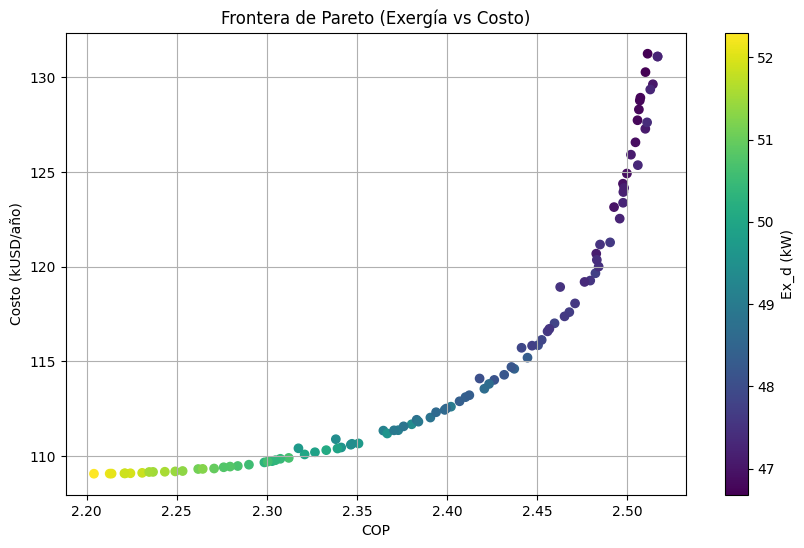

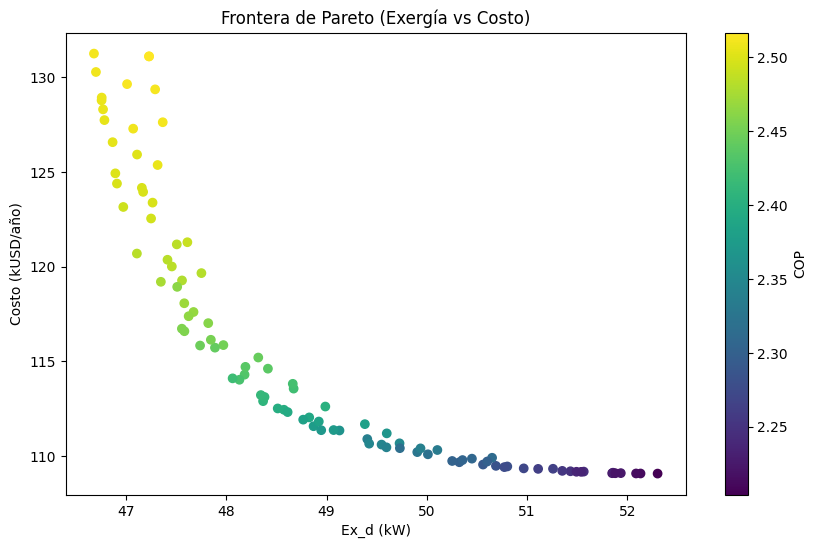

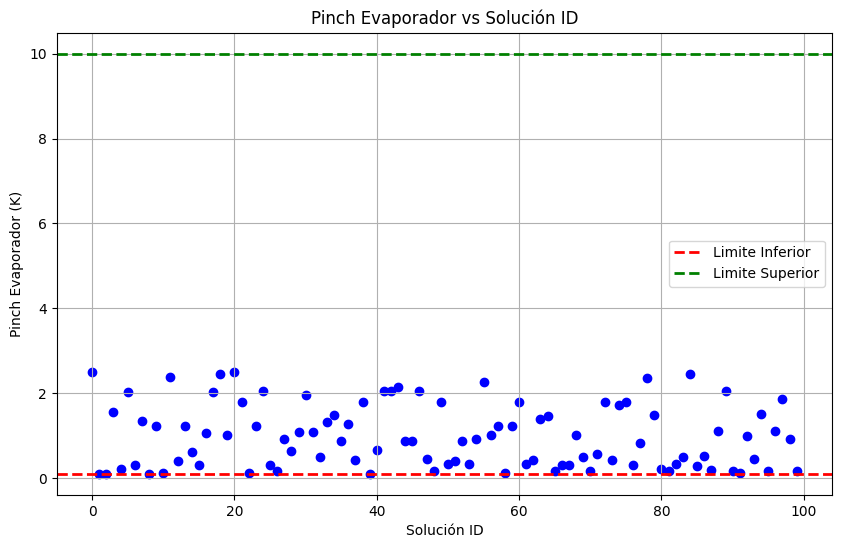

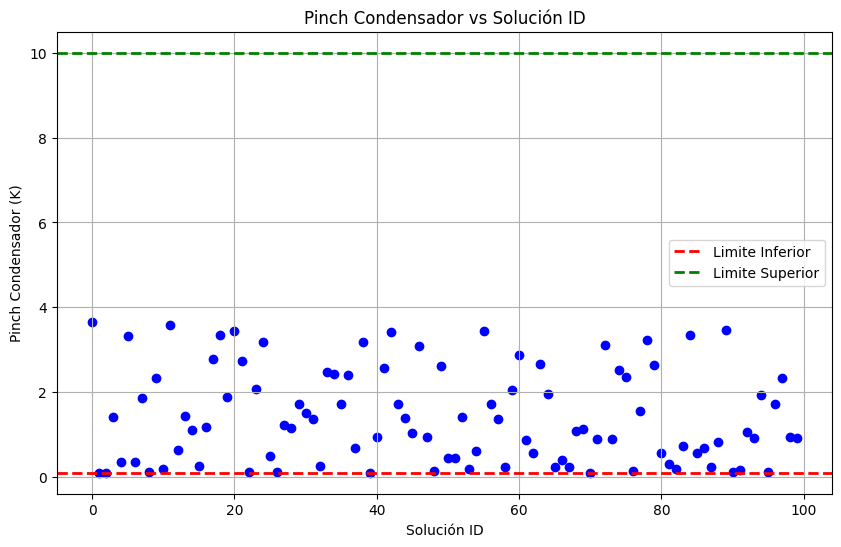

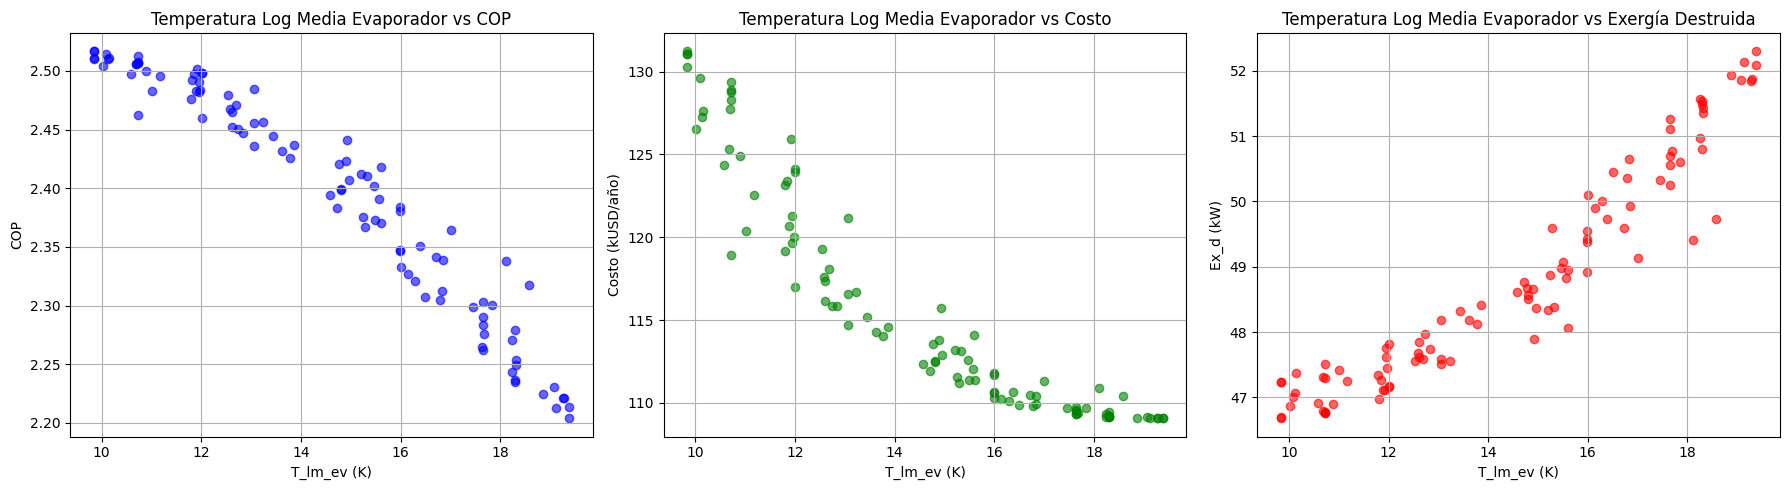

In [18]:
# -------------------------------------------------
# Función que monta el sistema y devuelve métricas
# -------------------------------------------------
def componentes4(pinch_ev, pinch_cond, T_dif):
    #Estos valores son fijos
    T_chamber = -25 + 273.15 #K
    T_out = 25 + 273.15 #K
    Q = 200e3 #W a enfriar


    eta_s = 0.8 #Eficiencia isentrópica
    Tsc = 5 #K, subrenfriamiento en condensador
    Tsh = 5 #k, sobrecalentamiento en evaporador
    T_amb = 25 + 273.15 #K, temperatura ambiente


    T_e_low = T_chamber - pinch_ev
    T_c_low = T_e_low + T_dif #Se fija T° del condensador del primer ciclo para que la temperatura sea 30 grados más que en el evaporador

    T_e_high = T_c_low - 10 #De tal manera que hayan 10 K de diferencia en el intercambiador
    T_c_high = T_out + pinch_cond #Temperatura es mayor que el ambiente


    fluid_low = 'R41'
    fluid_high = 'R290'

    #Y para el evaporador de baja temperatura
    m_g_e_low = 1.5 #kg/s
    rho_e_low = 850 #kg/m3
    cp_e_low = 2100 #J/kgK

    k_h = 0.13 #W/mk
    mu_h = 3.5*10**(-3) #Pa*s

    glicol = refrigerante(cp=cp_e_low, rho=rho_e_low, k=k_h, mu=mu_h) #Fluido caliente en el ev. para el ciclo de baja T
    aire = refrigerante(cp=1000, rho=1, k=0.024, mu=1.81*10**(-5)) #Fluido frío en el cond. del ciclo de alta T

    m_aire = 5 #kg/s

    U_e_low = 800 #Caso base
    U_c_high = 800 #Caso base

    Np = 2 #Número de pasos
    Nt = 80 #Número de tubos
    di = 0.01 #m, diametro interno
    t = 0.002 #m, espesor

    try:
        # crear intercambiadores usando los pinch dados
        HX_ev_low = HX(T_c_in=T_e_low, m_h=m_g_e_low, U=U_e_low, pinch=pinch_ev,
                       Np=Np, Nt=Nt, di=di, t=t,
                       fluid_c=fluid_low, fluid_h=glicol, tipo='evaporador')

        HX_cond_high = HX(T_c_in=T_amb, U=U_c_high, pinch=pinch_cond,
                          Np=Np, Nt=Nt, di=di, t=t,
                          fluid_h=fluid_high, fluid_c=aire, tipo='condensador')

        # instancia ciclo cascada con estos HX
        ciclo_combinado = VCR_cascada(Q=Q,
                                     T_ev_low=T_e_low, T_cond_low=T_e_low + T_dif,
                                     T_ev_high=T_e_high, T_cond_high=T_c_high,
                                     ref1=fluid_low, ref2=fluid_high,
                                     eta_c_low=eta_s, eta_c_high=eta_s,
                                     Tsh=Tsh, Tsc=Tsc, T_amb=T_amb,
                                     T_chamber=T_chamber, m_g_e_low=m_g_e_low, m_aire=m_aire,
                                     ref_e_low=glicol, U_e_low=U_e_low,
                                     HX_e_low=HX_ev_low, HX_c_high=HX_cond_high)

        # En caso de que tu clase calcule valores en init y solve, ya están listos
        COP = ciclo_combinado.COP
        costo = ciclo_combinado.costo
        Ex_d_total = ciclo_combinado.Ex_d_total

        # extrae otras variables para restricciones / diagnóstico
        T_lm_ev = ciclo_combinado.T_lm_e_low
        T_lm_cond = ciclo_combinado.T_lm_c_high
        m_dot_low = ciclo_combinado.m_dot_low
        m_dot_high = ciclo_combinado.m_dot_high
        Pe_low = ciclo_combinado.Pe_low
        Pc_low = ciclo_combinado.Pc_low
        Pe_high = ciclo_combinado.Pe_high
        Pc_high = ciclo_combinado.Pc_high

        A_e_low = ciclo_combinado.HX_e_l.A
        A_c_high = ciclo_combinado.HX_c_h.A
        A_HX = ciclo_combinado.A_HX

        out ={ 
            "COP": COP,
            "Ex_dest": Ex_d_total,
            "costo": costo,
            "T_lm_ev": T_lm_ev,
            "T_lm_cond": T_lm_cond,
            "m_dot_low": m_dot_low,
            "m_dot_high": m_dot_high,
            "Pe_low": Pe_low,
            "Pc_low": Pc_low,
            "Pe_high": Pe_high,
            "Pc_high": Pc_high,
            "A_e_low": A_e_low,
            "A_c_high": A_c_high,
            "A_HX": A_HX,
            "ok": True,
        }

    except Exception as e:
        out["ok"] = False

    return out



class ciclo_multi4(ElementwiseProblem):
    def __init__(self):
        super().__init__(
            n_var=3, #Pinch en el ev. y cond. + Tdif cascada
            n_obj=3,  #Función objetivo: minimizar Ex_dest y C_total y maximizar COP
            n_constr=8, #
            xl=np.array([0.1, 0.1, 25]),
            xu=np.array([10, 10, 35])
        )
    
    
    def _evaluate(self, x, out, *args, **kwargs):
        solucion = componentes4(x[0], x[1], x[2])
        COP = solucion["COP"]
        costo = solucion["costo"]
        Ex_d = solucion["Ex_dest"]

        m_dot_l = solucion["m_dot_low"]
        m_dot_h = solucion["m_dot_high"]
        Pc_low = solucion["Pc_low"]
        Pe_low = solucion["Pe_low"]
        Pc_high = solucion["Pc_high"]
        Pe_high = solucion["Pe_high"]
        Ae_low = solucion["A_e_low"]
        Ac_high = solucion["A_c_high"]
        AHX = solucion["A_HX"]


        #Restricc g<=0
        g1 = -m_dot_l
        g2 = -m_dot_h

        # Relación de compresión ≤ 8-10 para eficiencia y seguridad
        rc_low = Pc_low / Pe_low
        rc_high = Pc_high / Pe_high
        #g8 = rc_low - 50.0  # rc_low ≤ 10
        #g9 = rc_high - 50.0  # rc_high ≤ 10
        # Áreas mínimas y máximas para intercambiadores
        g10 = 0.1 - Ae_low    # A_evap ≥ 0.1 m²
        g11 = 0.1 - Ac_high   # A_cond ≥ 0.1 m²  
        g12 = 0.1 - AHX       # A_HX ≥ 0.1 m²

        g13 = Ae_low - 200     # A_evap ≤ 50 m²
        g14 = Ac_high - 200    # A_cond ≤ 50 m²
        g15 = AHX - 200        # A_HX ≤ 20 m²

        f1 = -COP
        f2 = costo
        f3 = Ex_d
        out["F"] = [f1, f2, f3]
        out["G"] = [g1, g2, g10, g11, g12, g13, g14, g15]
        #out["G"] = [g1, g2, g8, g9, g10, g11, g12, g13, g14, g15]


problema4 = ciclo_multi4()

solucion4 = minimize(problema4,
               algoritmo,
               ('n_gen', 50),
               seed=1,
               verbose=True)




F4 = solucion4.F   # matriz de objetivos [f1, f2]
X4 = solucion4.X   # matriz de variables de decisión

df_fo = pd.DataFrame(F, columns=['-COP', 'Costo (USD/año)', 'Ex_d (W)'])
df_fo["-COP"] = -df_fo['-COP']
df_fo.rename(columns={'-COP': 'COP'}, inplace=True)

df_fo["Costo (USD/año)"] = df_fo["Costo (USD/año)"]/1000  #kUSD/año
df_fo.rename(columns={'Costo (USD/año)': 'Costo (kUSD/año)'}, inplace=True)

df_fo["Ex_d (W)"] = df_fo["Ex_d (W)"]/1000  #kW
df_fo.rename(columns={'Ex_d (W)': 'Ex_d (kW)'}, inplace=True)

df_vo = pd.DataFrame(X, columns=["pinch_e","pinch_cond", "T_casc" ])

variables = {"COP": [], "Ex_dest" : [], "costo": [] , "T_lm_ev": [], "T_lm_cond": [], "m_dot_low": [], "m_dot_high": [], "Pe_low": [], "Pc_low": [], "Pe_high": [], "Pc_high": [], "A_e_low": [], "A_c_high": [], "A_HX": [] }
for i in range(len(df_vo)):
    resultado = componentes(df_vo.loc[i, "pinch_e"], df_vo.loc[i, "pinch_cond"], df_vo.loc[i, "T_casc"])
    for key in variables.keys():
        variables[key].append(resultado[key])
for key in variables.keys():
    df_vo[key] = variables[key]

df_vo


plt.figure(figsize=(10,6))
plt.scatter(df_fo["COP"], df_fo["Costo (kUSD/año)"], c=df_fo["Ex_d (kW)"], cmap='viridis')
plt.colorbar(label='Ex_d (kW)')
plt.xlabel("COP")
plt.ylabel("Costo (kUSD/año)")
plt.title("Frontera de Pareto (Exergía vs Costo)")
plt.grid(True)
plt.show()


plt.figure(figsize=(10,6))
plt.scatter(df_fo['Ex_d (kW)'], df_fo['Costo (kUSD/año)'], c = df_fo["COP"], cmap = "viridis")
plt.ylabel('Costo (kUSD/año)')
plt.xlabel('Ex_d (kW)')
plt.colorbar(label='COP')
plt.title("Frontera de Pareto (Exergía vs Costo)")



n_id = [i for i in range(len(df_vo))]


xl=np.array([0.1, 0.1, 25])
xu=np.array([10, 10, 35])


plt.figure(figsize=(10,6))
plt.scatter(n_id, df_vo['pinch_e'], color='blue')
plt.axhline(y=xl[0], color='r', linestyle='--', linewidth=2, label='Limite Inferior')
plt.axhline(y=xu[0], color='g', linestyle='--', linewidth=2, label='Limite Superior')
plt.xlabel('Solución ID')
plt.ylabel('Pinch Evaporador (K)')
plt.title('Pinch Evaporador vs Solución ID')
plt.legend()
plt.grid(True)
plt.show()



plt.figure(figsize=(10,6))
plt.scatter(n_id, df_vo['pinch_cond'], color='blue')
plt.axhline(y=xl[1], color='r', linestyle='--', linewidth=2, label='Limite Inferior')
plt.axhline(y=xu[1], color='g', linestyle='--', linewidth=2, label='Limite Superior')
plt.xlabel('Solución ID')   
plt.ylabel('Pinch Condensador (K)')
plt.title('Pinch Condensador vs Solución ID')
plt.legend()
plt.grid(True)
plt.show()


# Temperatura logarítmica media del evaporador vs funciones objetivo
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(df_vo['T_lm_ev'], df_fo['COP'], alpha=0.6, color='blue')
axes[0].set_xlabel('T_lm_ev (K)')
axes[0].set_ylabel('COP')
axes[0].set_title('Temperatura Log Media Evaporador vs COP')
axes[0].grid(True)

axes[1].scatter(df_vo['T_lm_ev'], df_fo['Costo (kUSD/año)'], alpha=0.6, color='green')
axes[1].set_xlabel('T_lm_ev (K)')
axes[1].set_ylabel('Costo (kUSD/año)')
axes[1].set_title('Temperatura Log Media Evaporador vs Costo')
axes[1].grid(True)

axes[2].scatter(df_vo['T_lm_ev'], df_fo['Ex_d (kW)'], alpha=0.6, color='red')
axes[2].set_xlabel('T_lm_ev (K)')
axes[2].set_ylabel('Ex_d (kW)')
axes[2].set_title('Temperatura Log Media Evaporador vs Exergía Destruida')
axes[2].grid(True)

plt.tight_layout()
plt.show()

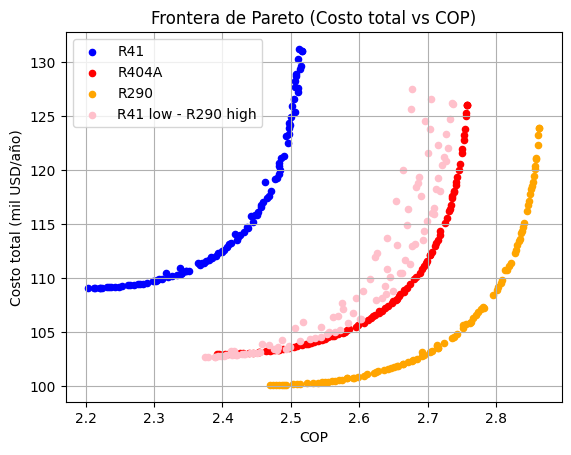

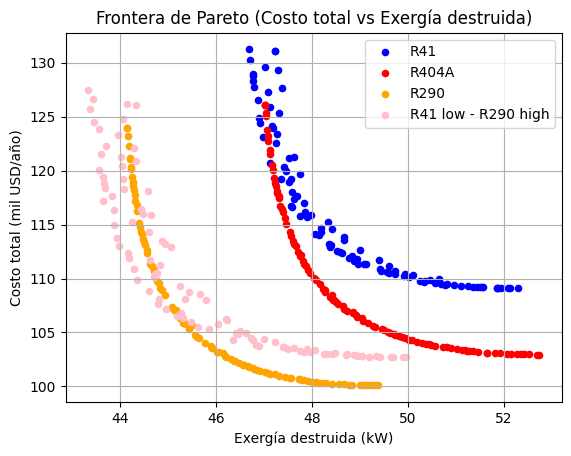

In [19]:
#R41
COP1 = -F[:,0]
Costo1 = F[:,1]/1000
Ex_d1 = F[:,2]/1000

#R404A
COP2 = -F2[:,0]
Costo2 = F2[:,1]/1000
Ex_d2 = F2[:,2]/1000

#R290
COP3 = -F3[:,0]
Costo3 = F3[:,1]/1000
Ex_d3 = F3[:,2]/1000

#R41 low - R290 high
COP4 = -F4[:,0]
Costo4 = F4[:,1]/1000
Ex_d4 = F4[:,2]/1000

plt.scatter(COP1, Costo1, c="blue", s=20, label='R41')
plt.scatter(COP2, Costo2, c="red", s=20, label='R404A')
plt.scatter(COP3, Costo3, c="orange", s=20, label='R290')
plt.scatter(COP4, Costo4, c="pink", s=20, label='R41 low - R290 high')
plt.xlabel("COP")
plt.ylabel("Costo total (mil USD/año)")
plt.title("Frontera de Pareto (Costo total vs COP)")
plt.legend()
plt.grid(True)
plt.show()

plt.scatter(Ex_d1, Costo1, c="blue", s=20, label='R41')
plt.scatter(Ex_d2, Costo2, c="red", s=20, label='R404A')
plt.scatter(Ex_d3, Costo3, c="orange", s=20, label='R290')
plt.scatter(Ex_d4, Costo4, c="pink", s=20, label='R41 low - R290 high')
plt.xlabel("Exergía destruida (kW)")
plt.ylabel("Costo total (mil USD/año)")
plt.title("Frontera de Pareto (Costo total vs Exergía destruida)")
plt.legend()
plt.grid(True)
plt.show()

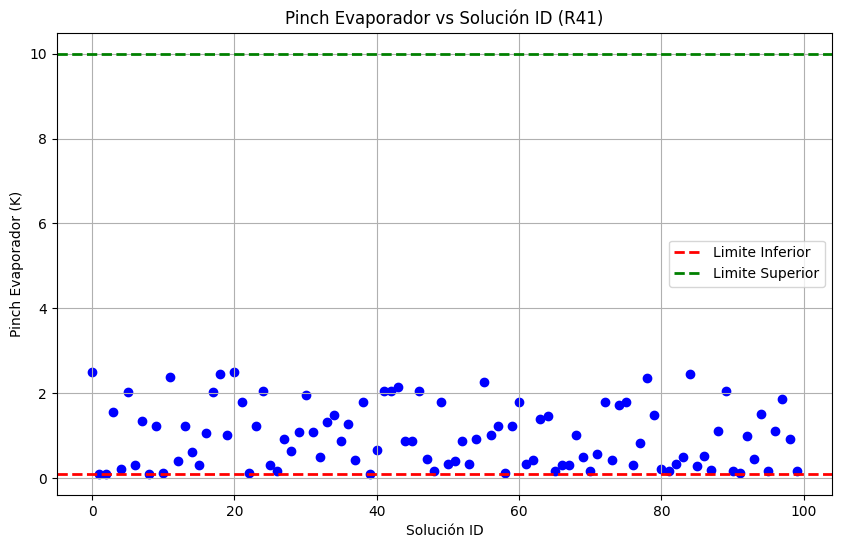

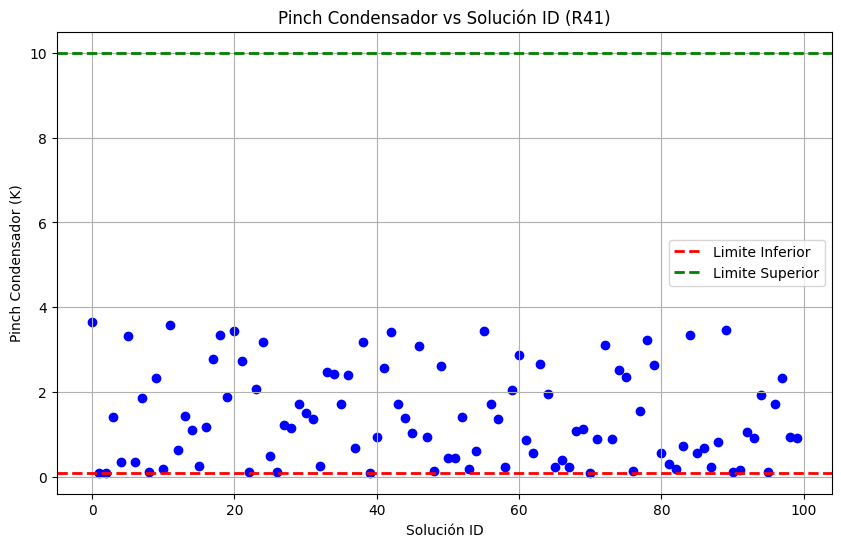

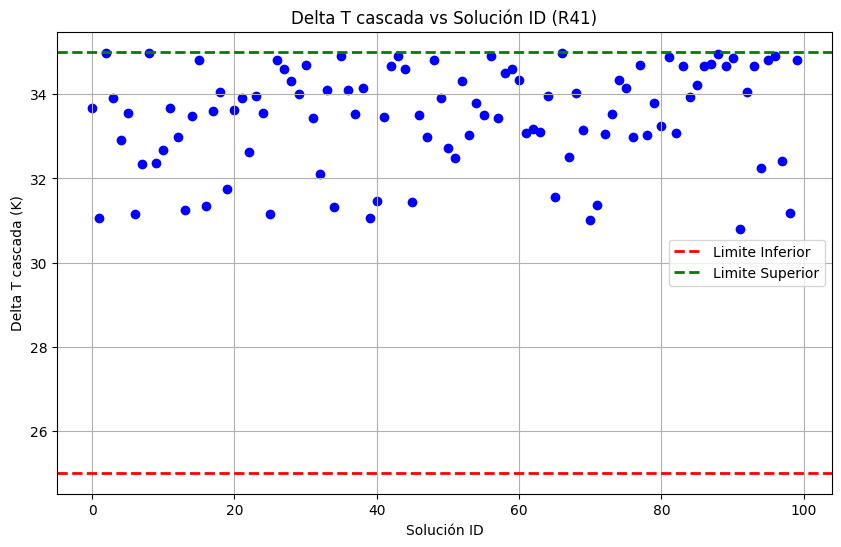

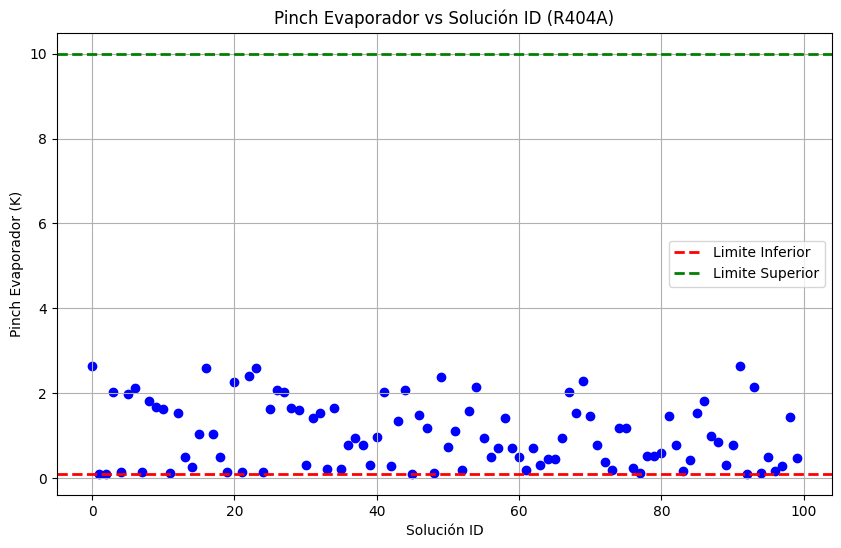

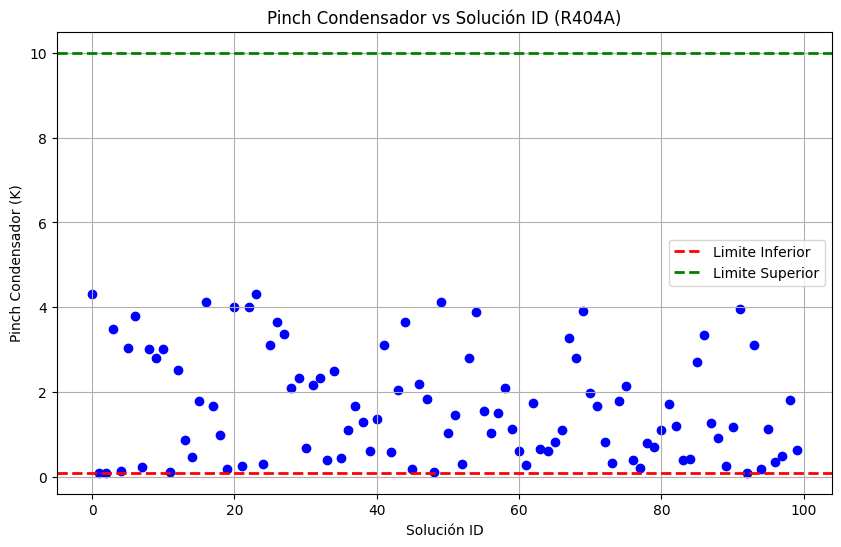

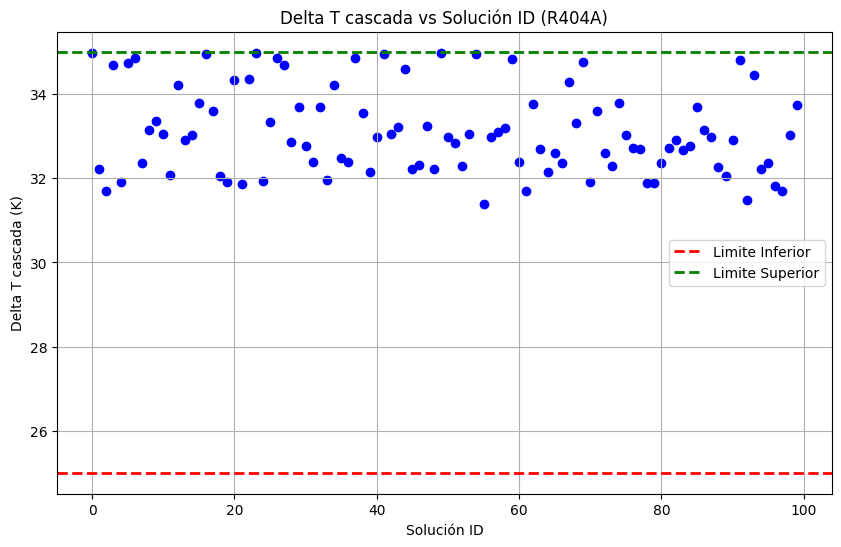

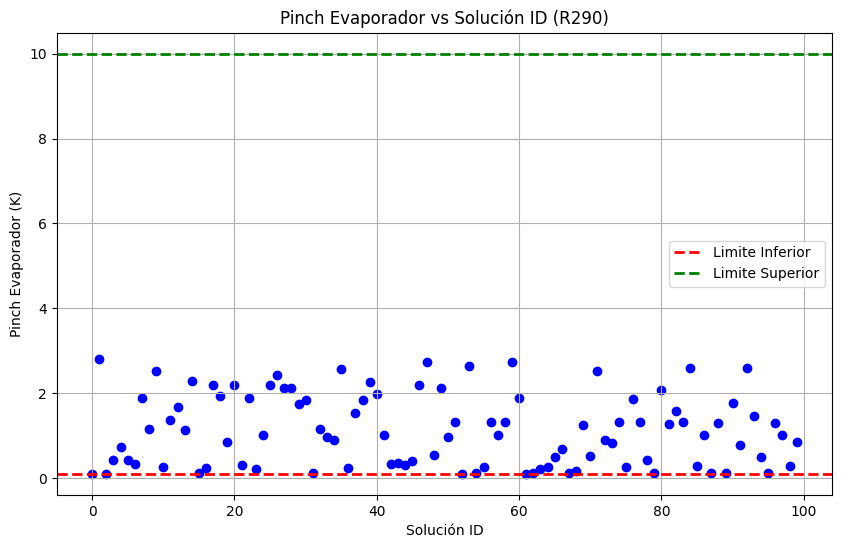

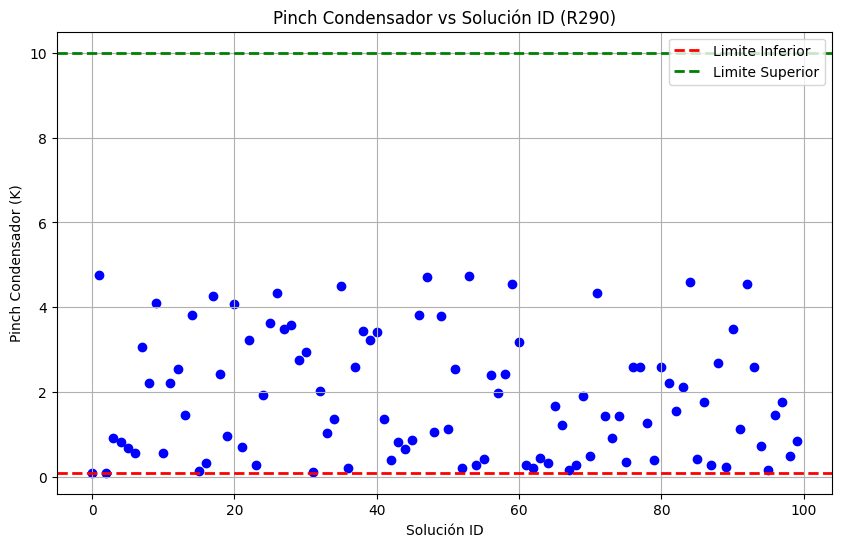

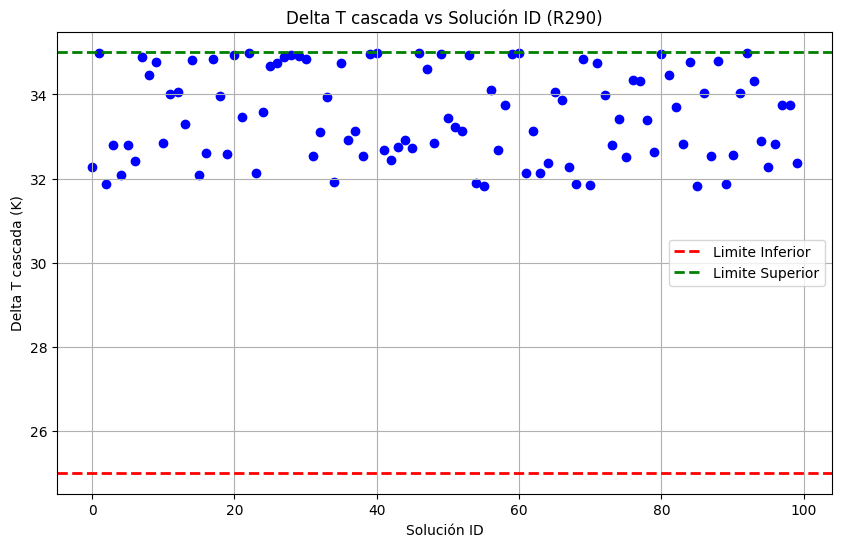

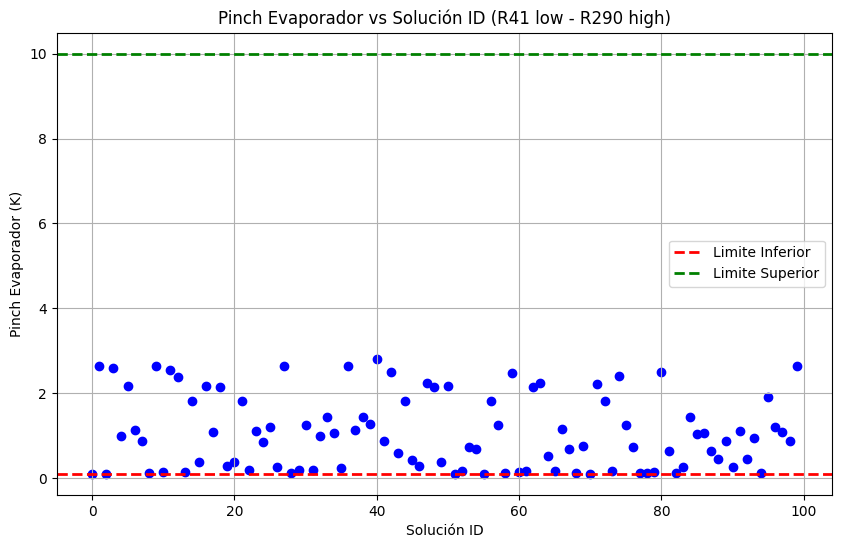

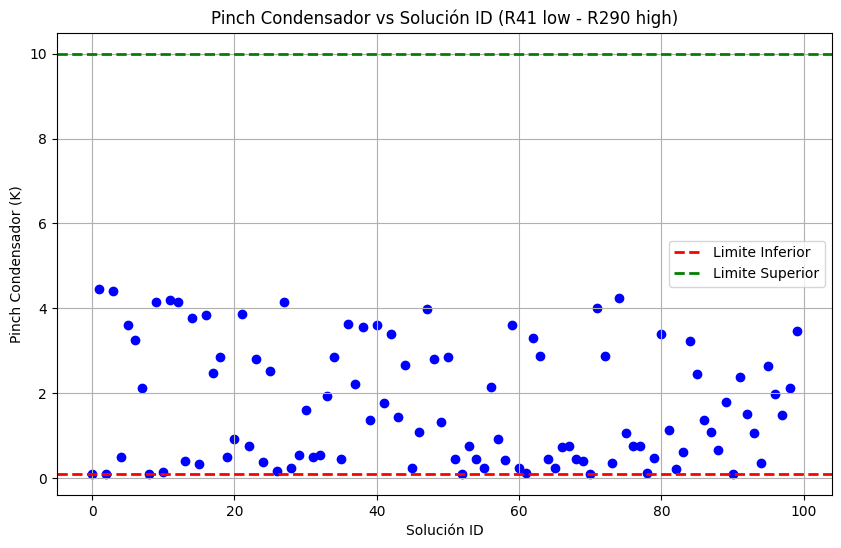

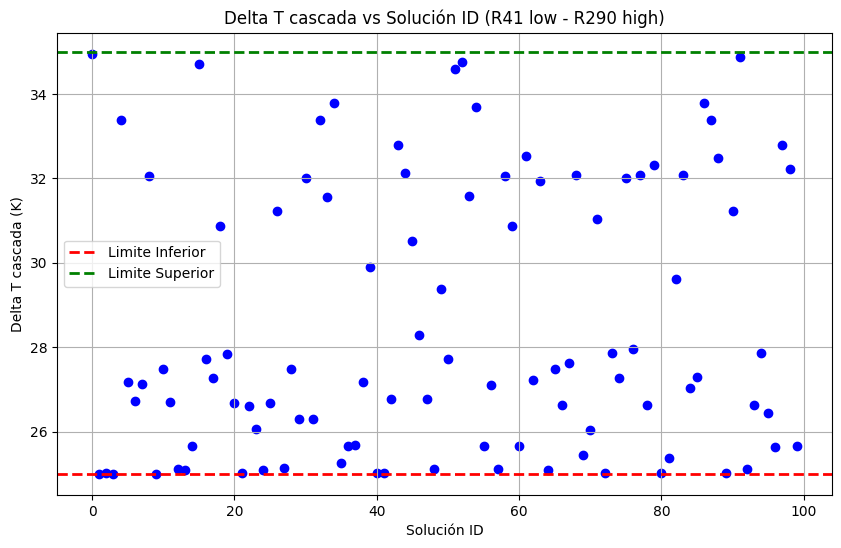

In [20]:
#R41
pinch_ev1 = X[:,0]
pinch_cond1 = X[:,1]
T_casc1 = X[:,2]

#R404A
pinch_ev2 = X2[:,0]
pinch_cond2 = X2[:,1]
T_casc2 = X2[:,2]

#R290
pinch_ev3 = X3[:,0]
pinch_cond3 = X3[:,1]
T_casc3 = X3[:,2]

#R41 low - R290 high
pinch_ev4 = X4[:,0]
pinch_cond4 = X4[:,1]
T_casc4 = X4[:,2]

plt.figure(figsize=(10,6))
plt.scatter(n_id, pinch_ev1, color='blue')
plt.axhline(y=xl[0], color='r', linestyle='--', linewidth=2, label='Limite Inferior')
plt.axhline(y=xu[0], color='g', linestyle='--', linewidth=2, label='Limite Superior')
plt.xlabel('Solución ID')
plt.ylabel('Pinch Evaporador (K)')
plt.title('Pinch Evaporador vs Solución ID (R41)')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10,6))
plt.scatter(n_id, pinch_cond1, color='blue')
plt.axhline(y=xl[1], color='r', linestyle='--', linewidth=2, label='Limite Inferior')
plt.axhline(y=xu[1], color='g', linestyle='--', linewidth=2, label='Limite Superior')
plt.xlabel('Solución ID')   
plt.ylabel('Pinch Condensador (K)')
plt.title('Pinch Condensador vs Solución ID (R41)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
plt.scatter(n_id, T_casc1, color='blue')
plt.axhline(y=xl[2], color='r', linestyle='--', linewidth=2, label='Limite Inferior')
plt.axhline(y=xu[2], color='g', linestyle='--', linewidth=2, label='Limite Superior')
plt.xlabel('Solución ID')   
plt.ylabel('Delta T cascada (K)')
plt.title('Delta T cascada vs Solución ID (R41)')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10,6))
plt.scatter(n_id, pinch_ev2, color='blue')
plt.axhline(y=xl[0], color='r', linestyle='--', linewidth=2, label='Limite Inferior')
plt.axhline(y=xu[0], color='g', linestyle='--', linewidth=2, label='Limite Superior')
plt.xlabel('Solución ID')
plt.ylabel('Pinch Evaporador (K)')
plt.title('Pinch Evaporador vs Solución ID (R404A)')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10,6))
plt.scatter(n_id, pinch_cond2, color='blue')
plt.axhline(y=xl[1], color='r', linestyle='--', linewidth=2, label='Limite Inferior')
plt.axhline(y=xu[1], color='g', linestyle='--', linewidth=2, label='Limite Superior')
plt.xlabel('Solución ID')   
plt.ylabel('Pinch Condensador (K)')
plt.title('Pinch Condensador vs Solución ID (R404A)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
plt.scatter(n_id, T_casc2, color='blue')
plt.axhline(y=xl[2], color='r', linestyle='--', linewidth=2, label='Limite Inferior')
plt.axhline(y=xu[2], color='g', linestyle='--', linewidth=2, label='Limite Superior')
plt.xlabel('Solución ID')   
plt.ylabel('Delta T cascada (K)')
plt.title('Delta T cascada vs Solución ID (R404A)')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10,6))
plt.scatter(n_id, pinch_ev3, color='blue')
plt.axhline(y=xl[0], color='r', linestyle='--', linewidth=2, label='Limite Inferior')
plt.axhline(y=xu[0], color='g', linestyle='--', linewidth=2, label='Limite Superior')
plt.xlabel('Solución ID')
plt.ylabel('Pinch Evaporador (K)')
plt.title('Pinch Evaporador vs Solución ID (R290)')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10,6))
plt.scatter(n_id, pinch_cond3, color='blue')
plt.axhline(y=xl[1], color='r', linestyle='--', linewidth=2, label='Limite Inferior')
plt.axhline(y=xu[1], color='g', linestyle='--', linewidth=2, label='Limite Superior')
plt.xlabel('Solución ID')   
plt.ylabel('Pinch Condensador (K)')
plt.title('Pinch Condensador vs Solución ID (R290)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
plt.scatter(n_id, T_casc3, color='blue')
plt.axhline(y=xl[2], color='r', linestyle='--', linewidth=2, label='Limite Inferior')
plt.axhline(y=xu[2], color='g', linestyle='--', linewidth=2, label='Limite Superior')
plt.xlabel('Solución ID')   
plt.ylabel('Delta T cascada (K)')
plt.title('Delta T cascada vs Solución ID (R290)')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10,6))
plt.scatter(n_id, pinch_ev4, color='blue')
plt.axhline(y=xl[0], color='r', linestyle='--', linewidth=2, label='Limite Inferior')
plt.axhline(y=xu[0], color='g', linestyle='--', linewidth=2, label='Limite Superior')
plt.xlabel('Solución ID')
plt.ylabel('Pinch Evaporador (K)')
plt.title('Pinch Evaporador vs Solución ID (R41 low - R290 high)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
plt.scatter(n_id, pinch_cond4, color='blue')
plt.axhline(y=xl[1], color='r', linestyle='--', linewidth=2, label='Limite Inferior')
plt.axhline(y=xu[1], color='g', linestyle='--', linewidth=2, label='Limite Superior')
plt.xlabel('Solución ID')   
plt.ylabel('Pinch Condensador (K)')
plt.title('Pinch Condensador vs Solución ID (R41 low - R290 high)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
plt.scatter(n_id, T_casc4, color='blue')
plt.axhline(y=xl[2], color='r', linestyle='--', linewidth=2, label='Limite Inferior')
plt.axhline(y=xu[2], color='g', linestyle='--', linewidth=2, label='Limite Superior')
plt.xlabel('Solución ID')   
plt.ylabel('Delta T cascada (K)')
plt.title('Delta T cascada vs Solución ID (R41 low - R290 high)')
plt.legend()
plt.grid(True)
plt.show()